**predicting turbine energy yield (TEY) using ambient variables as features.**

**Dataset: gas_turbines.csv**

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from imblearn.pipeline import Pipeline
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [ ]:
# Importing Dataset
from google.colab import files
uploaded=files.upload()

Saving gas_turbines.csv to gas_turbines.csv


In [ ]:
df=pd.read_csv('gas_turbines.csv')
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,111.61,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,111.78,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,110.19,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,110.74,10.533,6.2494,93.227


Data Exploration

In [ ]:
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [ ]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

Descriptive Analysis

In [ ]:
df.shape

(15039, 11)

In [ ]:
#Checking the data types
df.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [ ]:
#Unique values for every feature
df.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [ ]:
df[df.duplicated()].shape

(0, 11)

In [ ]:
df[df.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,17.764381,7.574323,0.522300,11.408000,18.1860,23.8625,34.9290
AP,15039.0,1013.199240,6.410760,985.850000,1008.900000,1012.8000,1016.9000,1034.2000
AH,15039.0,79.124174,13.793439,30.344000,69.750000,82.2660,90.0435,100.2000
AFDP,15039.0,4.200294,0.760197,2.087400,3.723900,4.1862,4.5509,7.6106
GTEP,15039.0,25.419061,4.173916,17.878000,23.294000,25.0820,27.1840,37.4020
TIT,15039.0,1083.798770,16.527806,1000.800000,1079.600000,1088.7000,1096.0000,1100.8000
TAT,15039.0,545.396183,7.866803,512.450000,542.170000,549.8900,550.0600,550.6100
TEY,15039.0,134.188464,15.829717,100.170000,127.985000,133.7800,140.8950,174.6100
CDP,15039.0,12.102353,1.103196,9.904400,11.622000,12.0250,12.5780,15.0810
CO,15039.0,1.972499,2.222206,0.000388,0.858055,1.3902,2.1604,44.1030


In [ ]:
df.corr()["TEY"].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [ ]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

Data Visualization

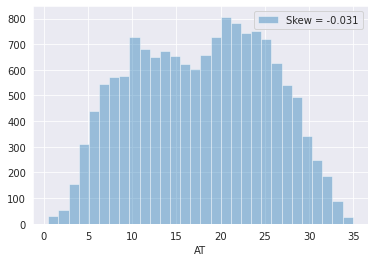

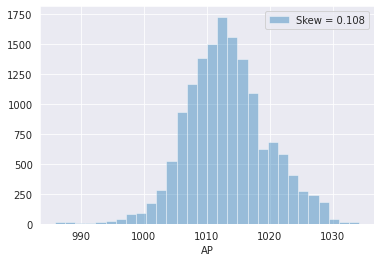

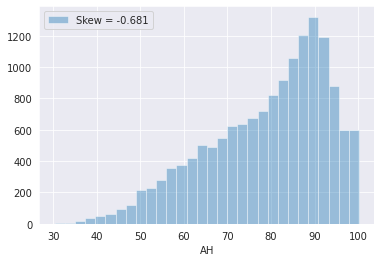

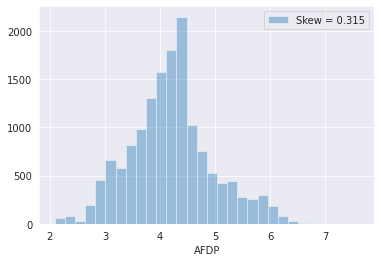

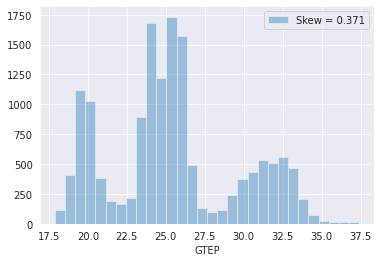

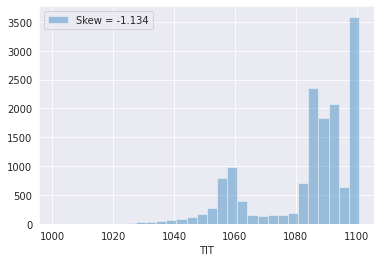

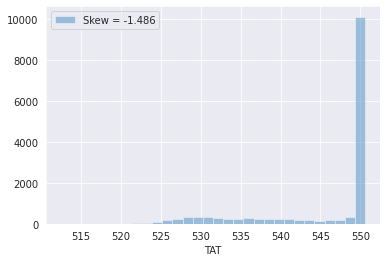

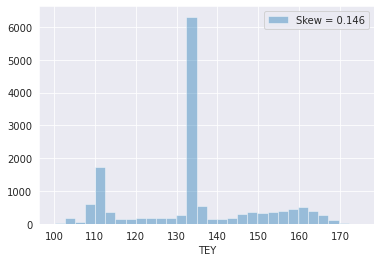

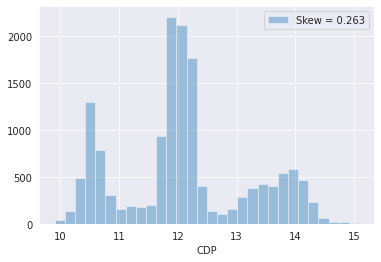

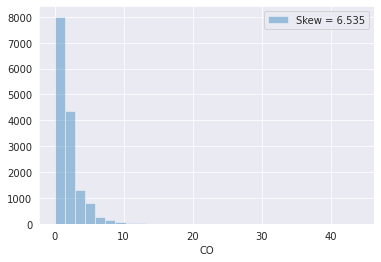

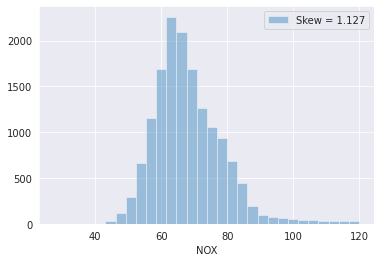

In [ ]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features])))) 

The dataset contains 1543 observations with more than 2 outliers


In [ ]:
numerical_features

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

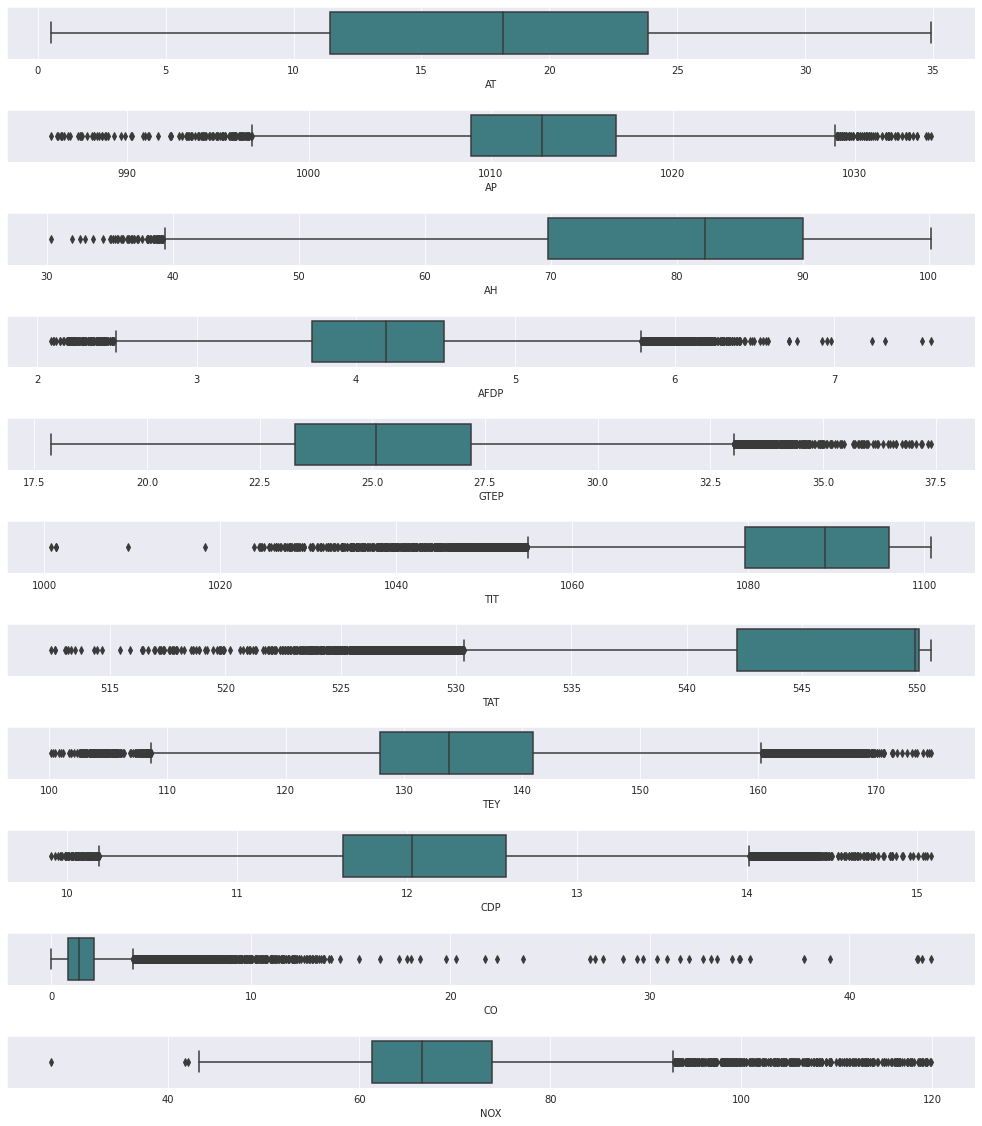

In [ ]:
ot=df.copy() 
fig, axes=plt.subplots(11,1,figsize=(14,16),sharex=False,sharey=False)
sns.boxplot(x='AT',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data=ot,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data=ot,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

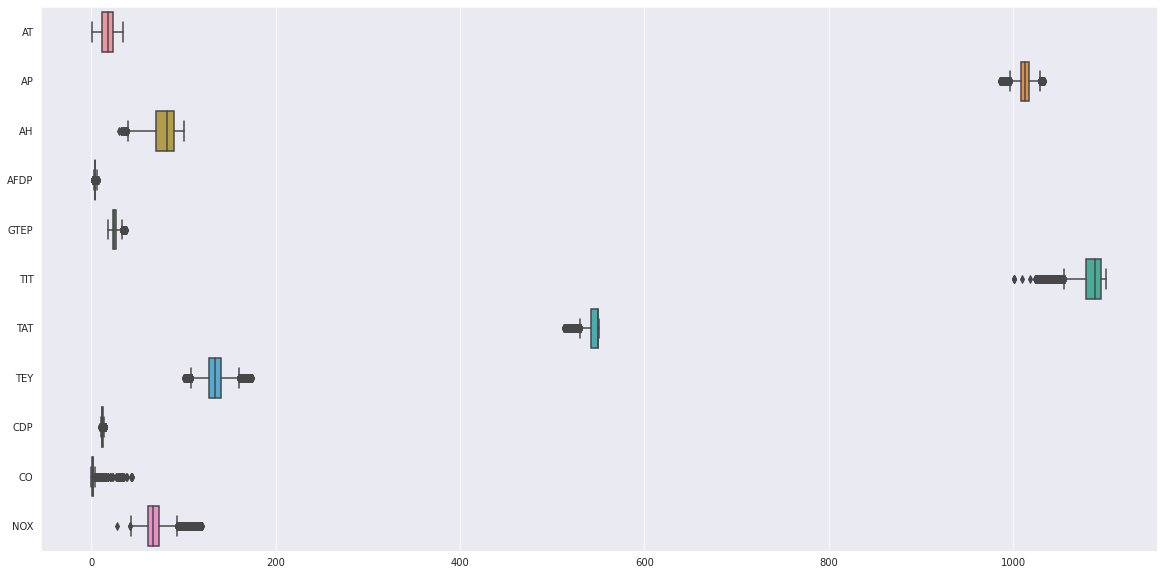

In [ ]:
#outlier
plt.figure(figsize=(20,10))
sns.boxplot(data=df[numerical_features], orient="h");

Text(0.5, 1.0, 'Histogram of the Target Column')

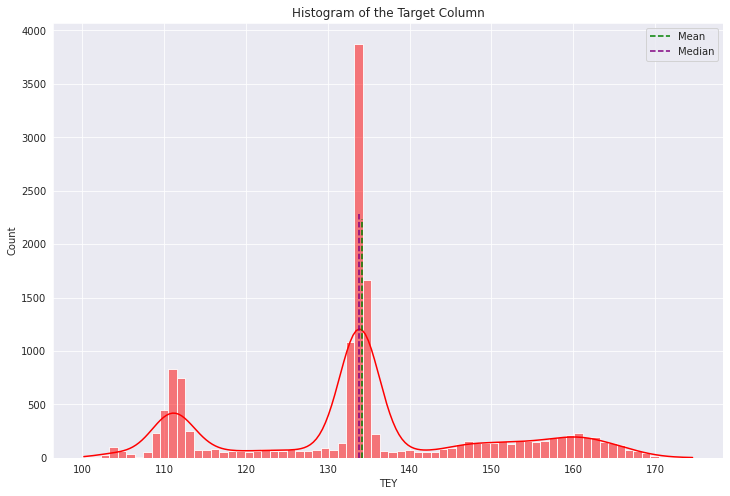

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,8))
sns.histplot(data=df,x="TEY",color="red",kde=True)
plt.axvline(x=df["TEY"].mean(),ymax=0.55,color="green",linestyle='--',label="Mean")
plt.axvline(x=df["TEY"].median(),ymax=0.56,color="purple",linestyle='--',label="Median")
plt.legend()
plt.title("Histogram of the Target Column")

Text(0.5, 1.0, 'Cumulative of the Target Column')

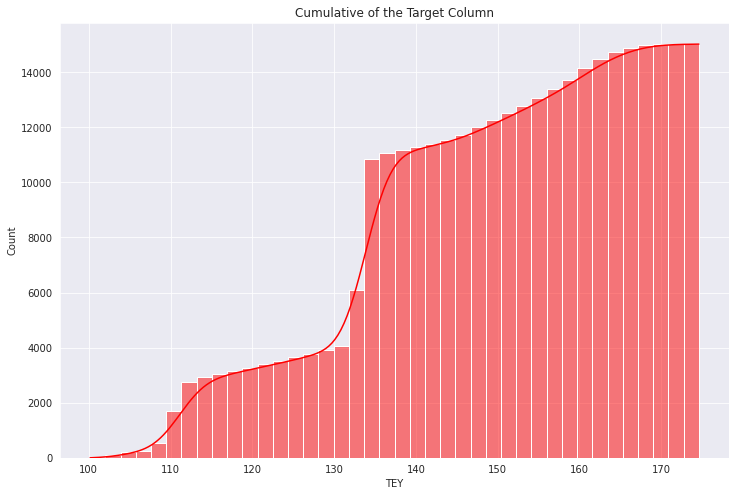

In [ ]:
plt.figure(figsize = (12,8))
sns.histplot(df["TEY"],kde=True,bins=40,color="red",cumulative=True)
plt.title("Cumulative of the Target Column")

Multivariate Analysis

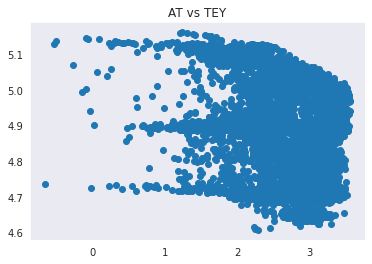

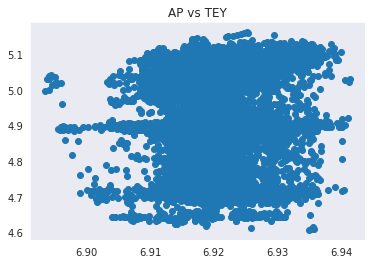

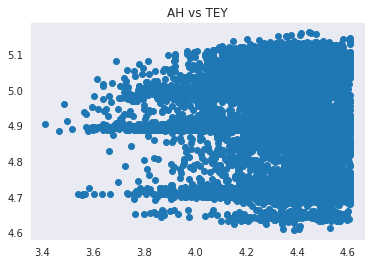

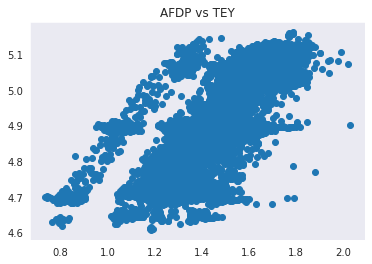

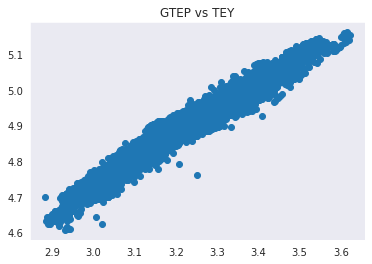

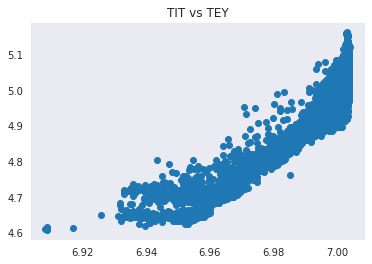

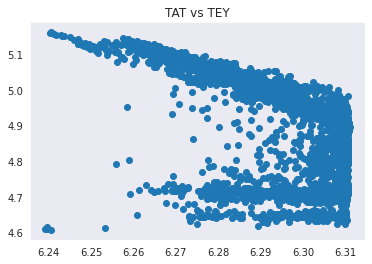

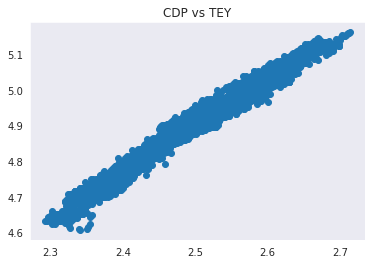

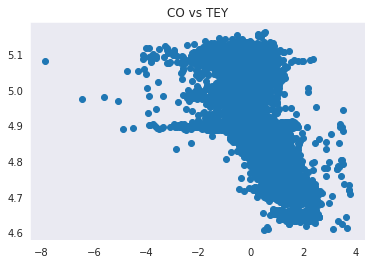

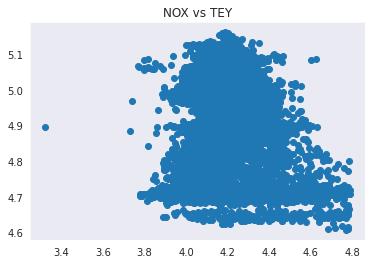

In [ ]:
for i in df.columns:
    if i!="TEY": 
        plt.scatter(np.log(df[i]), np.log(df['TEY']))
        plt.title(i+ ' vs TEY')
        plt.grid()
        plt.show()

<Figure size 1440x1440 with 0 Axes>

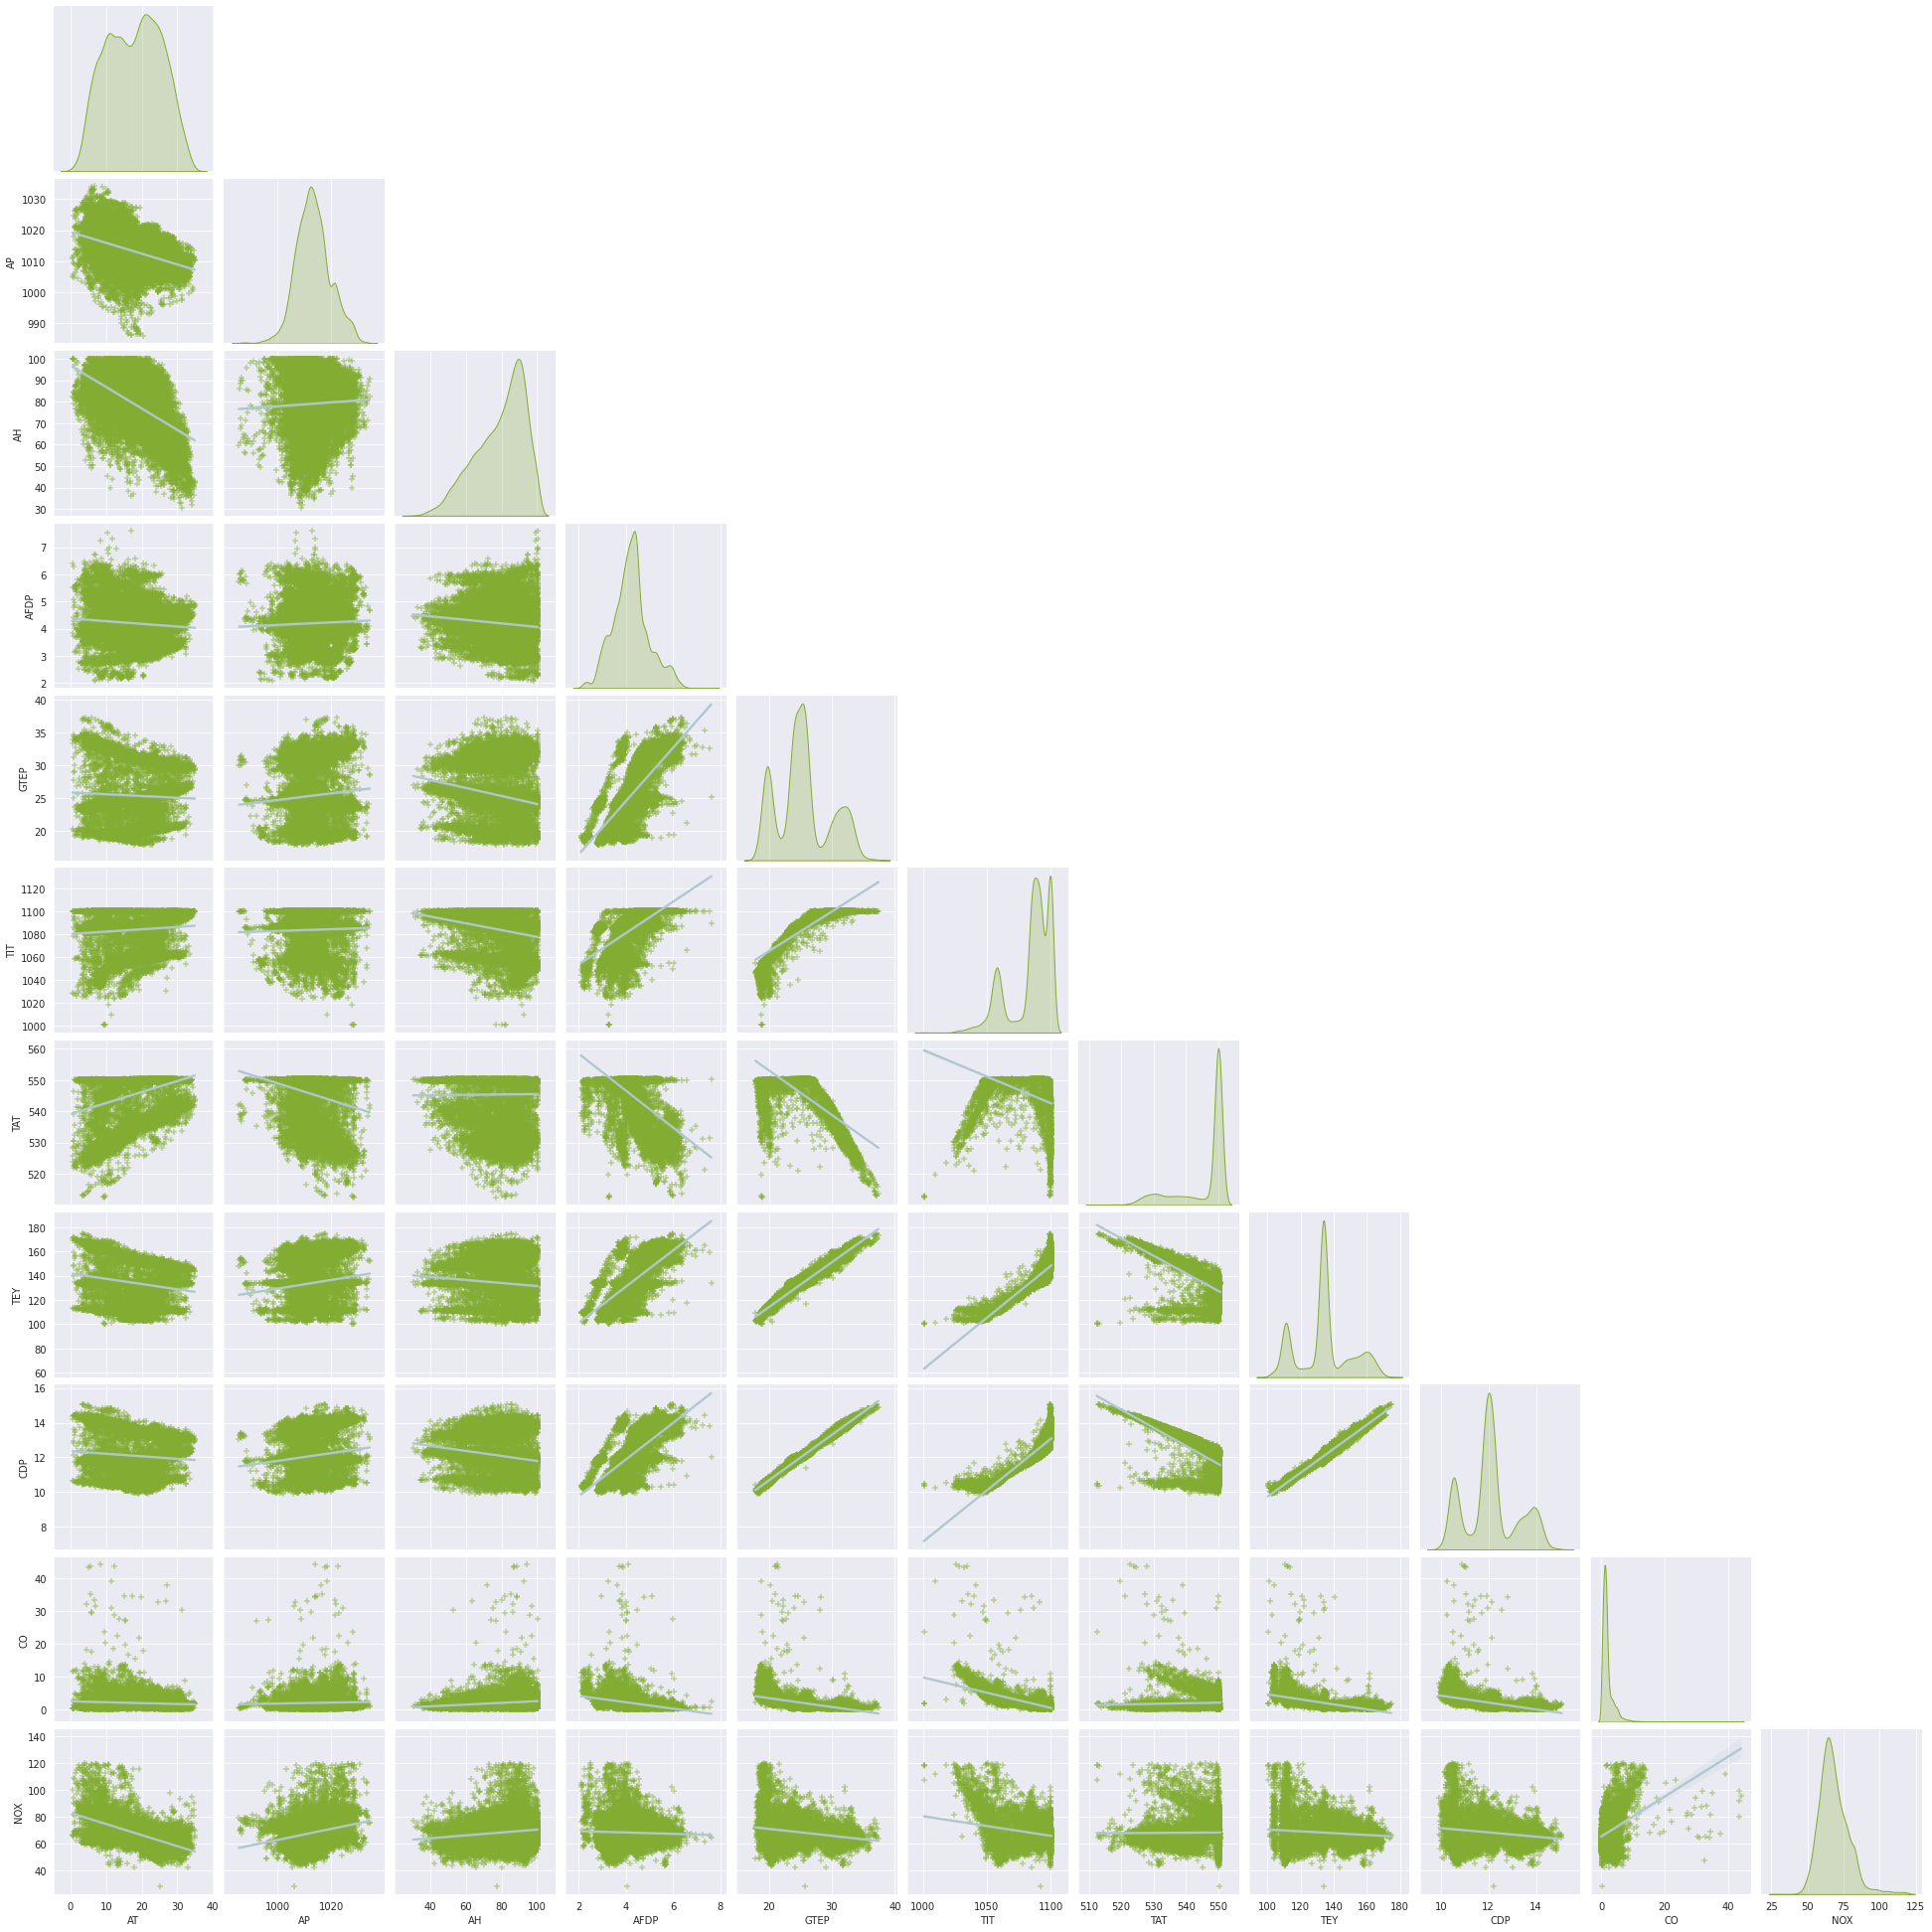

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(df,
                 markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})

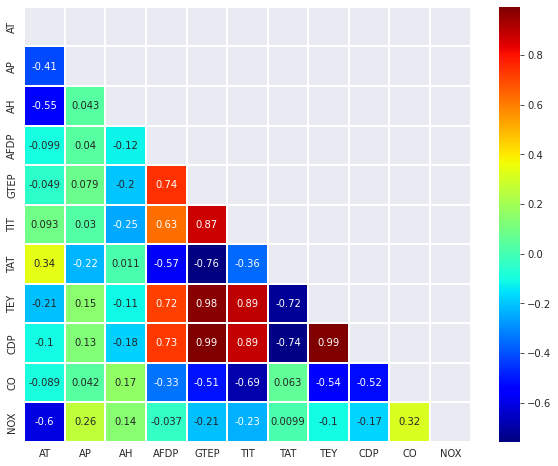

In [ ]:
# Having a look at the correlation matrix

plt.figure(figsize=(10,8))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=df.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)

In [ ]:
x = df.drop('TEY', axis=1)
y = df[["TEY"]]

Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

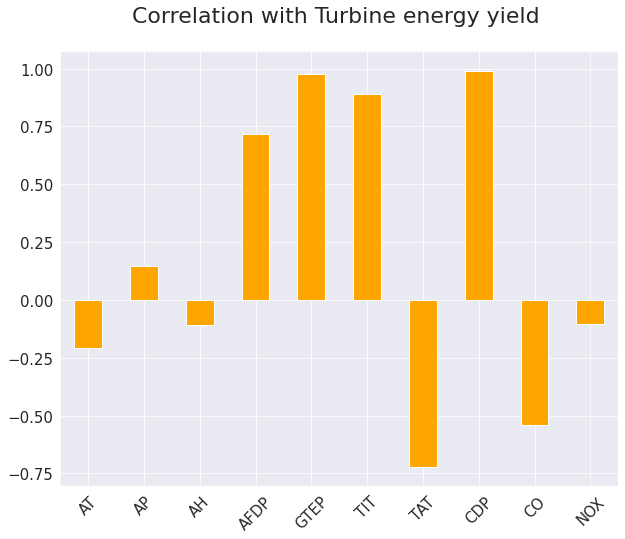

In [ ]:
data2 = df.copy()
correlations = data2.corrwith(df.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (10, 8), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

Feature Selection Technique

In [ ]:
#Feature importance
from numpy import set_printoptions

In [ ]:
# feature extraction
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)

In [ ]:
# summarize scores
scores = fit.scores_
features = fit.transform(x)

In [ ]:
score_df = pd.DataFrame(list(zip(scores, x.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
7,1.713643,CDP
4,1.600451,GTEP
5,1.323660,TIT
6,0.893991,TAT
3,0.660233,AFDP
8,0.512513,CO
0,0.412609,AT
9,0.300835,NOX
1,0.138510,AP
2,0.097738,AH


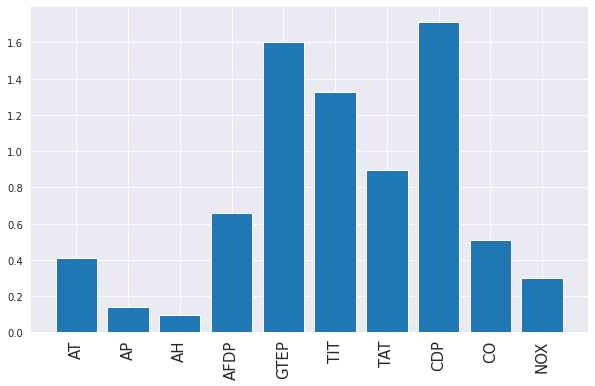

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

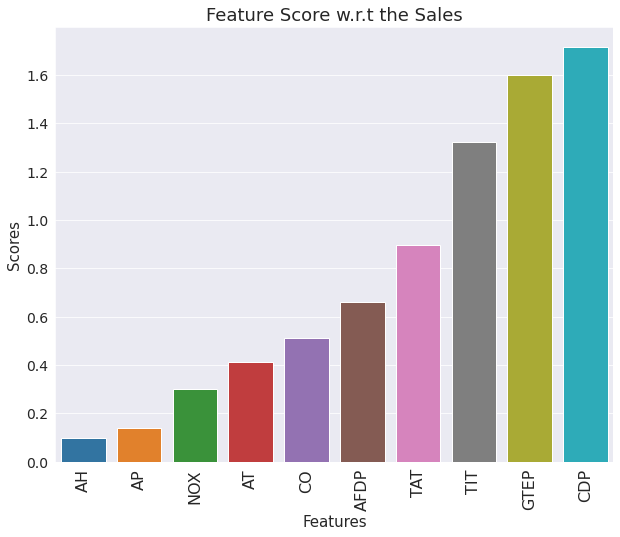

In [ ]:
plt.figure(figsize=(10,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [ ]:
score_df.sort_values('Score',ascending=False)

,Score,Feature
7,1.713643,CDP
4,1.600451,GTEP
5,1.323660,TIT
6,0.893991,TAT
3,0.660233,AFDP
8,0.512513,CO
0,0.412609,AT
9,0.300835,NOX
1,0.138510,AP
2,0.097738,AH


In [ ]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


In [ ]:
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 8


In [ ]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,-1.357331,-1.379101,-1.488376,0.585240,-0.921232,0.532012,-1.439778,-1.231172
1,-1.363676,-1.363528,-1.482325,0.585240,-0.921495,0.568733,-1.449601,-1.229909
2,-1.360957,-1.351309,-1.476275,0.568715,-0.944385,0.552938,-1.434721,-1.230541
3,-1.356424,-1.348194,-1.464173,0.583969,-0.946884,0.548933,-1.413702,-1.229909
4,-1.350985,-1.354663,-1.458123,0.582698,-0.924389,0.574179,-1.368693,-1.229909


The mean and standard deviation of our scaled data it should have a Mean '0' and Standard deviation '1'

In [ ]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1),'\n' 'Standard Deviation','\n',np.round(df_standard_scaled.std()),1)

Mean
 CDP     0.0
GTEP   -0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT      0.0
TEY     0.0
dtype: float64 
Standard Deviation 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64 1


In [ ]:
x = df.drop(labels='TEY',axis=1)
y = df[['TEY']]

In [ ]:
x

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,10.533,6.2494,93.227


In [ ]:
y

,TEY
0,114.70
1,114.72
2,114.71
3,114.72
4,114.72
...,...
15034,111.61
15035,111.78
15036,110.19
15037,110.74


**Hyperparameter Tuning**

**Tuning of Hyperparameters :-**

1)Batch Size

2)Epochs

In [ ]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

In [ ]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam=Adam(learning_rate=0.001)
    model1.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model1

In [ ]:
model1 =KerasRegressor(build_fn=create_model,verbose=0)
batch_size=[10,20,40,50]
epochs=[10,50,100,200]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=KFold(),verbose=10)

In [ ]:
grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.055 total time=   7.1s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.044 total time=  11.2s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.072 total time=  11.2s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.049 total time=  11.1s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.047 total time=  11.2s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ...batch_size=10, epochs=50;,

In [ ]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.03050720877945423, using {'batch_size': 50, 'epochs': 100}
-0.05347216874361038,0.009955423815267213 with {'batch_size': 10, 'epochs': 10}
-0.031121981889009477,0.003900562461123856 with {'batch_size': 10, 'epochs': 50}
-0.03396473303437233,0.004055350642158931 with {'batch_size': 10, 'epochs': 100}
-0.03184978142380714,0.003841945892205947 with {'batch_size': 10, 'epochs': 200}
-0.04302288629114628,0.009237759569528447 with {'batch_size': 20, 'epochs': 10}
-0.0353353600949049,0.004617252792682849 with {'batch_size': 20, 'epochs': 50}
-0.03479701466858387,0.009636705542028416 with {'batch_size': 20, 'epochs': 100}
-0.031079063937067986,0.0029603690250340786 with {'batch_size': 20, 'epochs': 200}
-0.04130317121744156,0.0074877828072091816 with {'batch_size': 40, 'epochs': 10}
-0.03459309116005897,0.004353055447146988 with {'batch_size': 40, 'epochs': 50}
-0.034470393881201745,0.006369464089087354 with {'batch_size': 40, 'epochs': 100}
-0.032197211682796475,0.0035118117179333344 

**Tuning Hyperparameter: Optimal Dropout rate**

In [ ]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.001)
    model2.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model2

In [ ]:
model2=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)

In [ ]:
grid_result2 = grid2.fit(x_test,y_test) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.031 total time=  41.9s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.028 total time=  41.9s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.030 total time=  41.9s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.027 total time=  41.9s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.039 total time=  34.6s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END ............dropout_rate=0.1;, 

In [ ]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.02819567434489727, using {'dropout_rate': 0.4}
-0.030938808992505073,0.004126534404109719 with {'dropout_rate': 0.0}
-0.03078237920999527,0.0028511807786492692 with {'dropout_rate': 0.1}
-0.028884481638669968,0.0017248478555942596 with {'dropout_rate': 0.2}
-0.033305682614445685,0.001954323058976507 with {'dropout_rate': 0.3}
-0.02819567434489727,0.0032242528242879395 with {'dropout_rate': 0.4}
-0.03333485312759876,0.004147006965363246 with {'dropout_rate': 0.5}


**Optimal Learning rate ,Number of Layers and Neurons**

In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=100,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [ ]:
tuner = RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=5,  executions_per_trial=3,directory='project',project_name='Gas Turbine')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(x_train, y_train,epochs=100,validation_data=(x_test, y_test))

Trial 5 Complete [00h 04m 23s]
val_mean_absolute_error: 0.6077470580736796

Best val_mean_absolute_error So Far: 0.6063562432924906
Total elapsed time: 00h 27m 32s


In [ ]:
tuner.results_summary()

Results summary
Results in project/Gas Turbine
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 7
units_0: 64
units_1: 64
learning_rate: 0.001
units_2: 96
units_3: 96
units_4: 96
units_5: 32
units_6: 64
units_7: 32
units_8: 32
units_9: 96
units_10: 64
Score: 0.6063562432924906
Trial summary
Hyperparameters:
num_layers: 8
units_0: 64
units_1: 32
learning_rate: 0.001
units_2: 96
units_3: 64
units_4: 64
units_5: 32
units_6: 64
units_7: 32
units_8: 32
units_9: 64
units_10: 64
units_11: 64
units_12: 64
units_13: 64
units_14: 32
units_15: 32
units_16: 64
Score: 0.6077470580736796
Trial summary
Hyperparameters:
num_layers: 10
units_0: 96
units_1: 64
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
Score: 0.640097439289093
Trial summary
Hyperparameters:
num_layers: 11
units_0: 64
units_1: 64
learning_rate: 0.0001
units_2: 96
units_3: 96
units_4: 64
units_5: 64
units_6: 32
units_7: 96
units_8: 64
units_9: 96
u

 **Model Building Neural Networks**
 
Standardizing only predictor variable - after train test split

In [ ]:
model_data

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72
...,...,...,...,...,...,...,...,...
15034,10.400,19.164,1049.7,546.21,3.5421,4.5186,9.0301,111.61
15035,10.433,19.414,1046.3,543.22,3.5059,4.8470,7.8879,111.78
15036,10.483,19.530,1037.7,537.32,3.4770,7.9632,7.2647,110.19
15037,10.533,19.377,1043.2,541.24,3.4486,6.2494,7.0060,110.74


In [ ]:
#assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test) # scaling test data -- predictor

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

#for removing heading from y_test
#y_test = y_test.values

(12031, 7)
(3008, 7)
(12031, 1)
(3008, 1)


In [ ]:
# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 7)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train_scaled, y_train , batch_size=50, validation_split=0.3, epochs=100,  verbose=1)

Epoch 1/100
169/169 [==============================] - 1s 4ms/step - loss: 17686.8066 - mae: 132.0313 - mse: 17686.8066 - val_loss: 16856.6758 - val_mae: 128.8747 - val_mse: 16856.6758
Epoch 2/100
169/169 [==============================] - 1s 3ms/step - loss: 16356.7422 - mae: 126.9007 - mse: 16356.7422 - val_loss: 15797.3359 - val_mae: 124.6970 - val_mse: 15797.3359
Epoch 3/100
169/169 [==============================] - 0s 2ms/step - loss: 15377.4727 - mae: 122.9830 - mse: 15377.4727 - val_loss: 14876.0469 - val_mae: 120.9465 - val_mse: 14876.0469
Epoch 4/100
169/169 [==============================] - 0s 2ms/step - loss: 14490.3398 - mae: 119.3210 - mse: 14490.3398 - val_loss: 14021.6113 - val_mae: 117.3611 - val_mse: 14021.6113
Epoch 5/100
169/169 [==============================] - 0s 2ms/step - loss: 13659.6533 - mae: 115.7859 - mse: 13659.6533 - val_loss: 13215.7861 - val_mae: 113.8763 - val_mse: 13215.7861
Epoch 6/100
169/169 [==============================] - 0s 2ms/step - loss: 

In [ ]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):
        
    #defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20]
    epoch_list      = [5 , 10 , 50 , 100]
     
    bestParamTable = pd.DataFrame()
    
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)
                        
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))  
                        
            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]],
                                                        columns=['batchsize','epochs','Accuracy'] ))
            
          
            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)
finalParamTable


94/94 [==============================] - 0s 841us/step
batch_size: 5 - epochs: 5 Accuracy: TEY    98.061398
dtype: float64
94/94 [==============================] - 0s 864us/step
batch_size: 5 - epochs: 10 Accuracy: TEY    99.566886
dtype: float64
94/94 [==============================] - 0s 814us/step
batch_size: 5 - epochs: 50 Accuracy: TEY    99.667066
dtype: float64
94/94 [==============================] - 0s 819us/step
batch_size: 5 - epochs: 100 Accuracy: TEY    99.622315
dtype: float64
94/94 [==============================] - 0s 931us/step
batch_size: 10 - epochs: 5 Accuracy: TEY    80.812752
dtype: float64
94/94 [==============================] - 0s 930us/step
batch_size: 10 - epochs: 10 Accuracy: TEY    98.182445
dtype: float64
94/94 [==============================] - 0s 970us/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.689431
dtype: float64
94/94 [==============================] - 0s 832us/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.685448
dtype: float64
94/9

,batchsize,epochs,Accuracy
0,5,5,TEY 98.061398 dtype: float64
0,5,10,TEY 99.566886 dtype: float64
0,5,50,TEY 99.667066 dtype: float64
0,5,100,TEY 99.622315 dtype: float64
0,10,5,TEY 80.812752 dtype: float64
0,10,10,TEY 98.182445 dtype: float64
0,10,50,TEY 99.689431 dtype: float64
0,10,100,TEY 99.685448 dtype: float64
0,15,5,TEY 58.599176 dtype: float64
0,15,10,TEY 89.858088 dtype: float64


**Training Model - using best params**

In [ ]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')
# fitting the model to best params
model.fit(x_train_scaled,y_train, batch_size=20 , epochs = 100, verbose=0)

**Predicting values from Model using same dataset**

In [ ]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)


94/94 [==============================] - 0s 868us/step
(3008, 9)


,CDP,GTEP,TIT,TAT,AFDP,CO,AT,Actual,Predicted
13312,12.219,25.762,1092.5,550.25,4.0023,1.26430,24.0930,134.46,134.508286
12627,10.791,20.085,1059.6,549.94,3.2106,2.69370,20.4500,111.88,112.366486
6393,12.126,25.221,1089.9,549.62,4.5325,1.96250,20.2620,133.72,134.127258
4990,12.218,25.965,1092.9,549.96,4.4266,1.57120,26.8620,133.79,133.935318
12462,10.466,19.688,1056.9,550.01,3.1241,2.29960,19.4090,110.77,111.062637
7405,10.624,19.387,1058.9,550.17,3.3709,4.27640,2.2158,113.32,113.477516
10993,12.088,25.392,1089.7,550.11,3.7871,0.83578,23.8520,133.77,133.530960
9488,11.498,23.225,1079.4,549.60,4.2837,2.01980,12.3950,128.98,128.740204
14201,13.971,32.518,1100.1,528.98,5.1559,0.87760,12.3590,159.42,160.512131
9757,13.862,32.105,1100.0,530.69,5.9309,10.75000,8.6376,161.86,160.816986


In [ ]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis =1 , inplace = True)

** Calculating Absolute Percent Error and Error**

In [ ]:
# Computing the absolute percent error
APE=100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %']=APE
predictions_df.head()


The Accuracy for Test Data -- ANN model =  99.68914093446334


,Actual,Predicted,APE %
13312,134.46,134.508286,0.035911
12627,111.88,112.366486,0.434828
6393,133.72,134.127258,0.304561
4990,133.79,133.935318,0.108616
12462,110.77,111.062637,0.264185


In [ ]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

,Actual,Predicted,APE %,Error
0,134.46,134.508286,0.035911,-0.000359
1,111.88,112.366486,0.434828,-0.004348
2,133.72,134.127258,0.304561,-0.003046
3,133.79,133.935318,0.108616,-0.001086
4,110.77,111.062637,0.264185,-0.002642
...,...,...,...,...
3003,119.25,119.558006,0.258286,-0.002583
3004,133.74,134.014893,0.205543,-0.002055
3005,146.31,145.952011,0.244678,0.002447
3006,150.07,148.914429,0.770022,0.007700


**Visualizing the Relationship between the Actual and Predicted ValuesModel Validation**

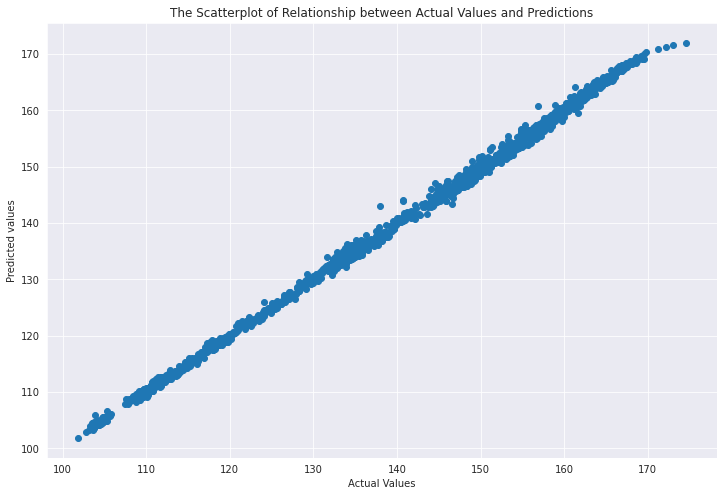

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

In [ ]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE: 0.421182247324193
MSE: 0.3354966395080584
RMSE: 0.5792207174368493


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train): ',r2_score(y_train, y_predict_train))
print('R2_score (test): ',r2_score(y_test, y_predict_test))


376/376 [==============================] - 1s 1ms/step
R2_score (train):  0.9984749149564021
R2_score (test):  0.9986601016345625


In [ ]:
#Evaluation of  the explained variance score (R^2)
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2))) 


This shows our model predict % 99.87 of the target correctly


**Residual Analysis**

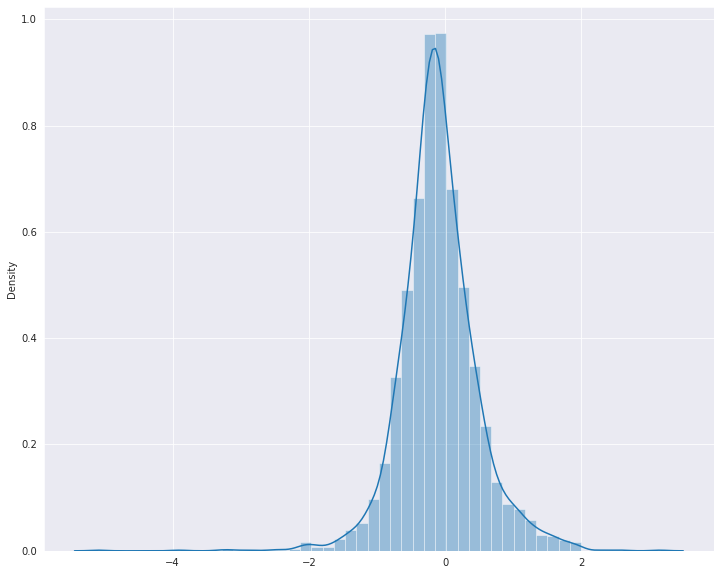

In [ ]:
#Now we will visualize the differences between our predictions and actual y test data
plt.figure(figsize=(12,10))
sns.distplot(y_test-y_predict_test,bins=50) #this figure also proves that our model fits very good
#There is no huge differences between our predictions and actual y data


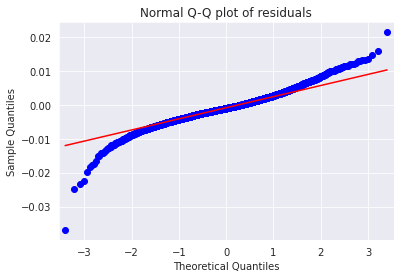

In [ ]:
#Residuals values  = y - yhat
import statsmodels.api as smf
smf.qqplot(predictions_df['Error'], line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()

**2) PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS**

In [ ]:
# Import Dataset
from google.colab import files
uploaded=files.upload()

Saving forestfires.csv to forestfires (1).csv


In [ ]:
raw_data=pd.read_csv('forestfires.csv')
raw_data

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,small


In [ ]:
pd.set_option('display.max_columns', None)
raw_data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small


**Data Exploration**

In [ ]:
# print shape of dataset with rows and columns
print(raw_data.shape)
# print top 5 records
raw_data.head()

(517, 31)


,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small


In [ ]:
# Descriptive Statistics
raw_data.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,0.164410,0.143133,0.162476,0.183752,0.117988,0.123791,0.104449,0.017408,0.355899,0.017408,0.038685,0.003868,0.061896,0.032882,0.104449,0.003868,0.001934,0.029014,0.332689
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,0.371006,0.350548,0.369244,0.387657,0.322907,0.329662,0.306138,0.130913,0.479249,0.130913,0.193029,0.062137,0.241199,0.178500,0.306138,0.062137,0.043980,0.168007,0.471632
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

In [ ]:
# Missing Values
raw_data.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
dayfri           0
daymon           0
daysat           0
daysun           0
daythu           0
daytue           0
daywed           0
monthapr         0
monthaug         0
monthdec         0
monthfeb         0
monthjan         0
monthjul         0
monthjun         0
monthmar         0
monthmay         0
monthnov         0
monthoct         0
monthsep         0
size_category    0
dtype: int64

In [ ]:
#Duplicated Values
raw_data[raw_data.duplicated()]

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
53,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,small
100,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,small
215,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,large
303,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,small
426,aug,thu,91.6,248.4,753.8,6.3,20.4,56,2.2,0.0,0.00,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,small
461,aug,sat,93.7,231.1,715.1,8.4,18.9,64,4.9,0.0,0.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,small
501,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,small
508,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,small


Numerical Variables

In [ ]:
# List of Numerical Variables
numerical_features=[feature for feature in raw_data.columns if raw_data[feature].dtypes != 'O']

print('Number of numerical variables:', len(numerical_features))

# Visualize the numerical variables
raw_data[numerical_features].head()

Number of numerical variables: 28


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Discrete Feature

In [ ]:
discrete_feature=[feature for feature in numerical_features if len(raw_data[feature].unique())<25]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))

Discrete Variables Count: 21


Continuous Variable

In [ ]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 7


Categorical Variables

In [ ]:
# find categorical variables

categorical = [var for var in raw_data.columns if raw_data[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 3 categorical variables

The categorical variables are :

 ['month', 'day', 'size_category']


In [ ]:
# view frequency counts of values in categorical variables

for var in categorical: 
    
    print(raw_data[var].value_counts())

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64
small    378
large    139
Name: size_category, dtype: int64


In [ ]:
# view frequency distribution of categorical variables

for var in categorical: 
    
    print(raw_data[var].value_counts()/np.float(len(raw_data)))

aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
jan    0.003868
may    0.003868
nov    0.001934
Name: month, dtype: float64
sun    0.183752
fri    0.164410
sat    0.162476
mon    0.143133
tue    0.123791
thu    0.117988
wed    0.104449
Name: day, dtype: float64
small    0.731141
large    0.268859
Name: size_category, dtype: float64


In [ ]:
# check for cardinality in categorical variables

for var in categorical:
    
    print(var, ' contains ', len(raw_data[var].unique()), ' labels')

month  contains  12  labels
day  contains  7  labels
size_category  contains  2  labels


In [ ]:
# Correlation
raw_data.corr()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
FFMC,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122,0.019306,-0.059396,-0.019637,-0.089517,0.071730,0.011225,0.093908,-0.117199,0.228103,-0.137044,-0.281535,-0.454771,0.031833,-0.040634,-0.074327,-0.037230,-0.088964,-0.005998,0.076609
DMC,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994,-0.012010,-0.107921,-0.003653,0.025355,0.087672,0.000016,0.017939,-0.197543,0.497928,-0.176301,-0.317899,-0.105647,-0.001946,-0.050403,-0.407404,-0.081980,-0.074218,-0.187632,0.110907
DC,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383,-0.004220,-0.052993,-0.035189,-0.001431,0.051859,0.028368,0.024803,-0.268211,0.279361,-0.105642,-0.399277,-0.115064,-0.100887,-0.186183,-0.650427,-0.114209,-0.078380,0.093279,0.531857
ISI,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258,0.046695,-0.158601,-0.038585,-0.003243,-0.022406,0.068610,0.125415,-0.106478,0.334639,-0.162322,-0.249777,-0.103588,0.020982,0.111516,-0.143520,-0.060493,-0.076559,-0.071154,-0.068877
temp,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844,-0.071949,-0.136529,0.034899,0.014403,0.051432,0.035630,0.090580,-0.157051,0.351404,-0.329648,-0.320015,-0.146520,0.142588,0.051015,-0.341797,-0.045540,-0.053798,-0.053513,0.088006
RH,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519,0.064506,0.009376,-0.023869,0.136220,-0.123061,-0.014211,-0.087508,0.021235,0.054761,-0.047714,0.140430,0.170923,0.013185,0.009382,-0.089836,0.086822,-0.035885,-0.072334,-0.062596
wind,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317,0.118090,-0.063881,-0.063799,0.027981,-0.062553,0.053396,-0.019965,0.048266,0.028577,0.269702,-0.029431,-0.070245,-0.040645,0.012124,0.181433,0.015054,0.011864,-0.053850,-0.181476
rain,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366,-0.004261,-0.029945,-0.032271,-0.017872,-0.026798,0.139311,-0.020744,-0.009752,0.093101,-0.009752,-0.014698,-0.004566,-0.013390,-0.013510,-0.020744,-0.004566,-0.003225,-0.012665,-0.051733
area,0.040122,0.072994,0.049383,0.008258,0.097844,-0.075519,0.012317,-0.007366,1.000000,-0.052911,-0.021206,0.087868,-0.020463,0.020121,-0.001333,-0.011452,-0.008280,-0.004187,0.001010,-0.020732,-0.012589,0.006149,-0.020314,-0.045596,0.006264,-0.008893,-0.016878,0.056573
dayfri,0.019306,-0.012010,-0.004220,0.046695,-0.071949,0.064506,0.118090,-0.004261,-0.052911,1.000000,-0.181293,-0.195372,-0.210462,-0.162237,-0.166728,-0.151487,-0.019140,-0.100837,-0.019140,0.046323,-0.027643,-0.048969,0.006000,0.036205,0.056423,-0.019527,-0.045585,0.107671


**Data Visualization**

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 <a list of 28 Text major ticklabel objects>)

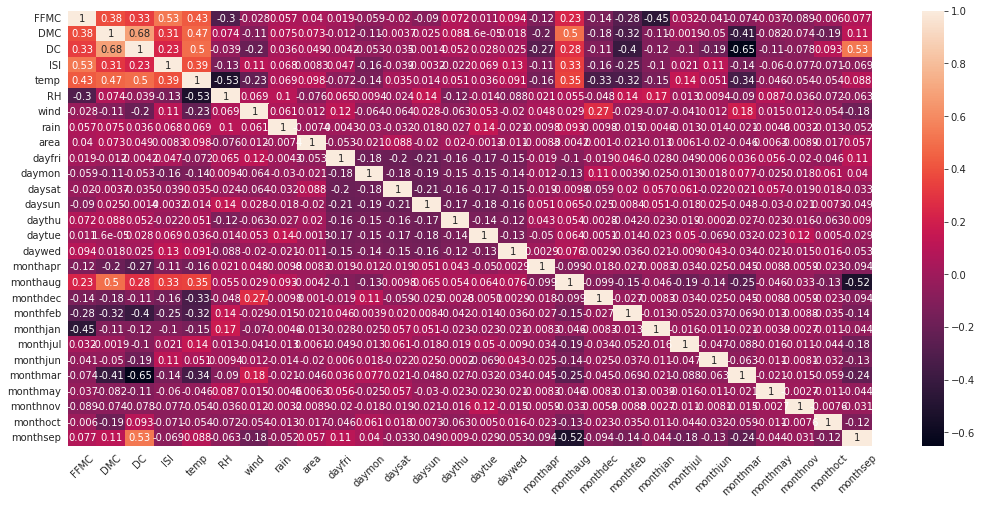

In [ ]:
fig= plt.figure(figsize=(18, 8))
sns.heatmap(raw_data.corr(), annot=True);
plt.xticks(rotation=45)

Univariate plots

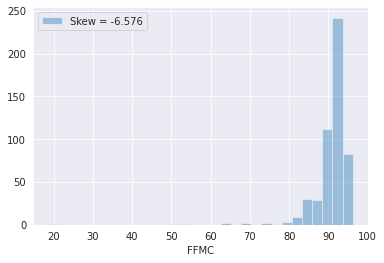

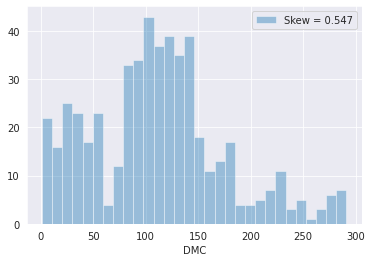

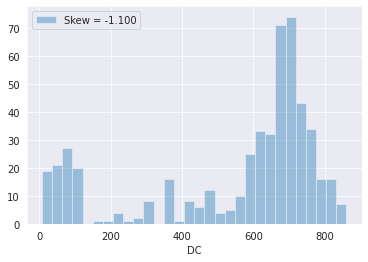

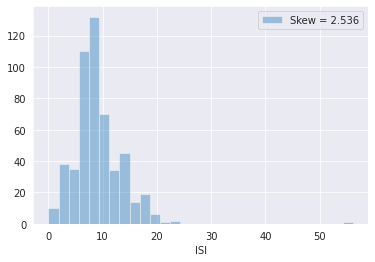

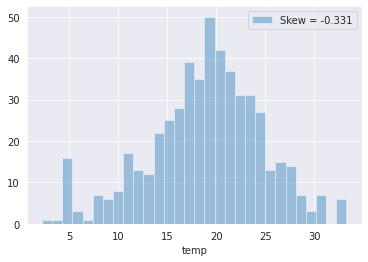

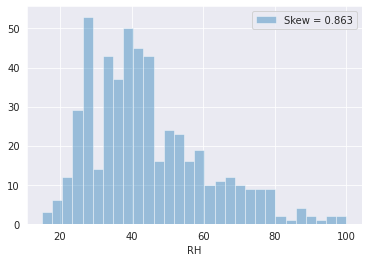

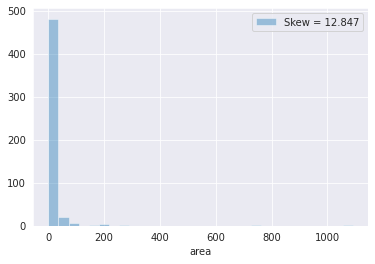

In [ ]:
for feat in continuous_feature:
    skew = raw_data[feat].skew()
    sns.distplot(raw_data[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(raw_data[continuous_feature]))))

The dataset contains 3 observations with more than 2 outliers


**Outliers Detection**

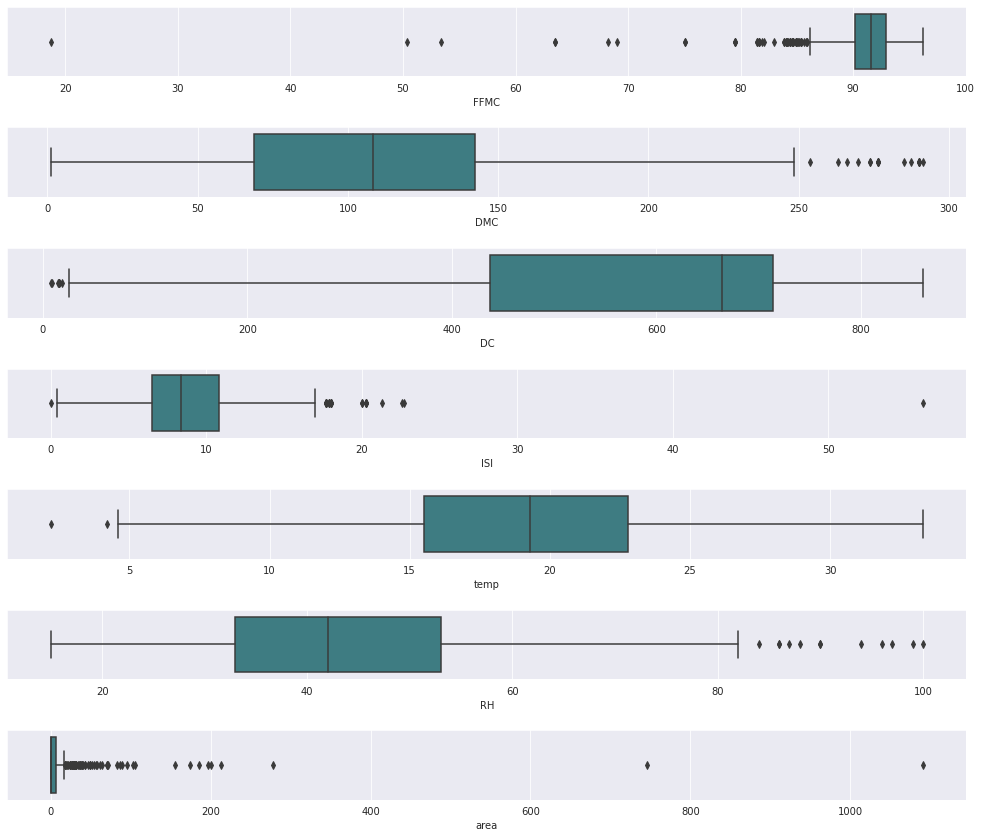

In [ ]:
ot=raw_data.copy() 
fig, axes=plt.subplots(7,1,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='FFMC',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='DMC',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='DC',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='ISI',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='temp',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='RH',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='area',data=ot,palette='crest',ax=axes[6])
plt.tight_layout(pad=2.0)

There are lot of outliers present in the dataframe but we can't drop them because they are present in a very large quantity and can be important for model building

**After Log-Transformation**

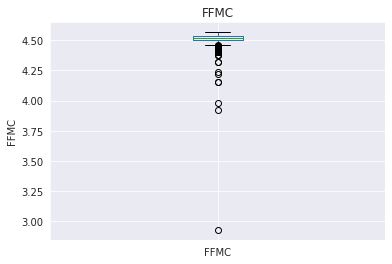

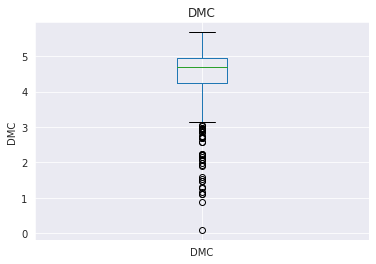

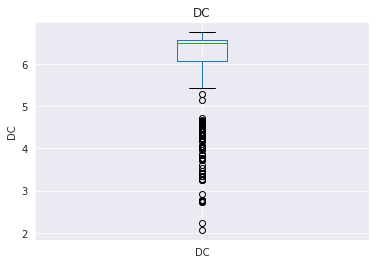

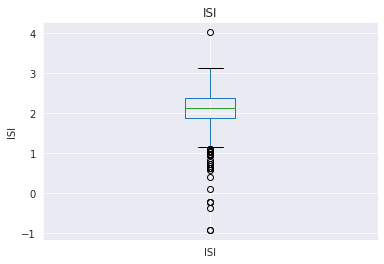

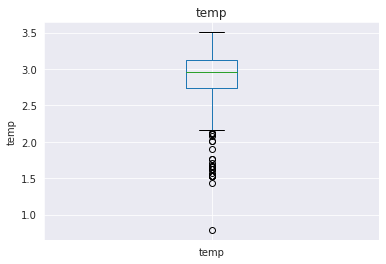

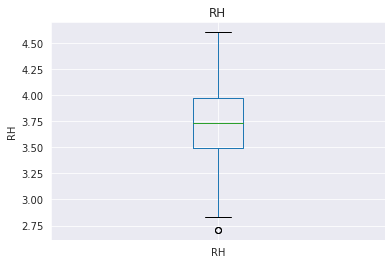

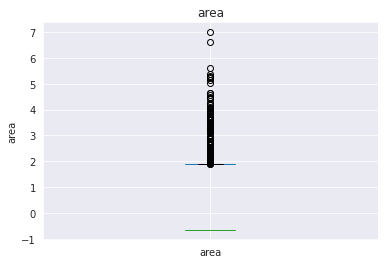

In [ ]:
for feature in continuous_feature:
    data=raw_data.copy()
    data[feature]=np.log(data[feature])
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

**Visualize the distribution of 'Area' and taking insights**

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


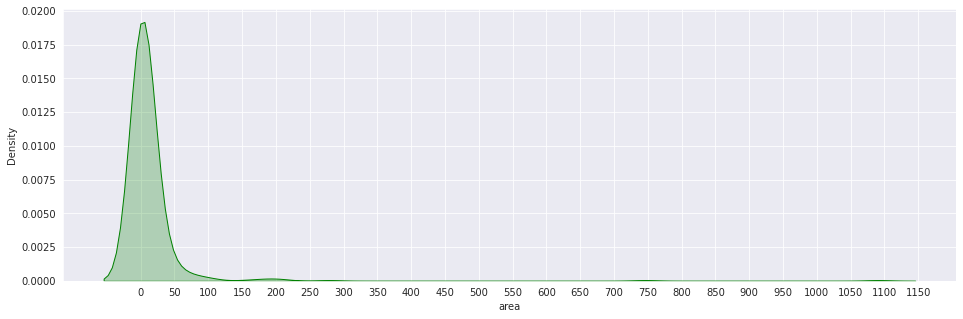

In [ ]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(raw_data['area'].skew()))
print("Kurtosis: {}".format(raw_data['area'].kurtosis()))
ax = sns.kdeplot(raw_data['area'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

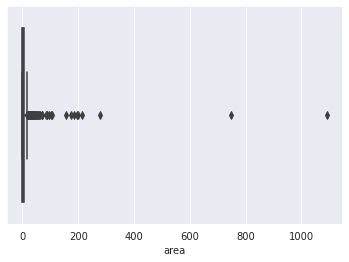

In [ ]:
ax = sns.boxplot(raw_data['area'])

In [ ]:
categorical_features=[feature for feature in raw_data.columns if raw_data[feature].dtype=='O']
print('Number of Categorical Features:',len(categorical_features), '\n', categorical_features)
raw_data[categorical_features].head()

Number of Categorical Features: 3 
 ['month', 'day', 'size_category']


,month,day,size_category
0,mar,fri,small
1,oct,tue,small
2,oct,sat,small
3,mar,fri,small
4,mar,sun,small


In [ ]:
for feature in categorical_features:
    print("{} number of unique categories in feature named {}".format(len(raw_data[feature].unique()),feature))

12 number of unique categories in feature named month
7 number of unique categories in feature named day
2 number of unique categories in feature named size_category


In [ ]:
# Decide which categorical variables you want to use in model
for feature in raw_data.columns:
    if raw_data[feature].dtypes == 'object':# in pandas it is object
        unique_cat = len(raw_data[feature].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=feature, unique_cat=unique_cat))
        print(raw_data[feature].value_counts())
        print()

Feature 'month' has 12 unique categories
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

Feature 'day' has 7 unique categories
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

Feature 'size_category' has 2 unique categories
small    378
large    139
Name: size_category, dtype: int64



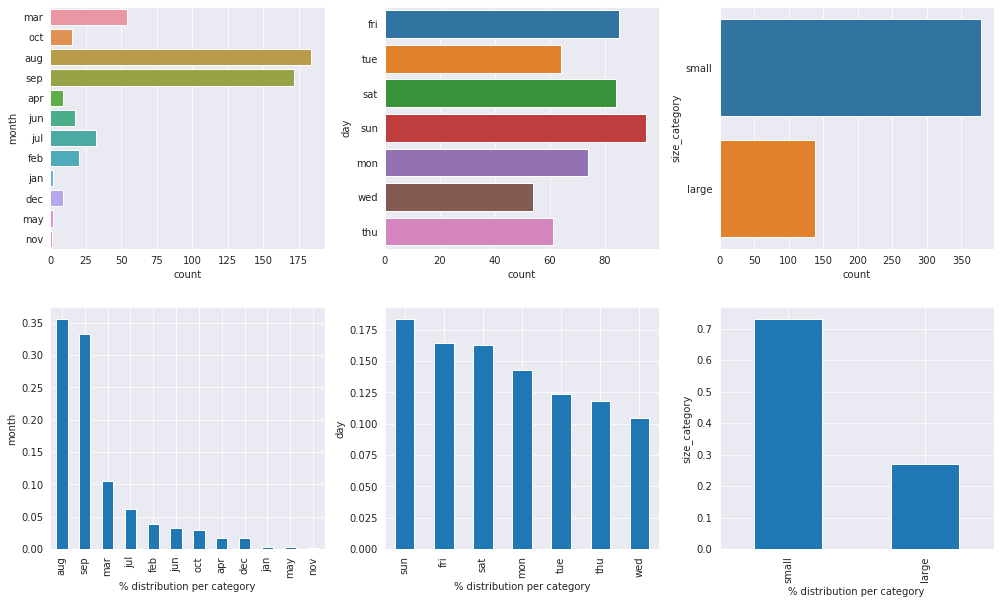

In [ ]:
# analyzing categorical columns
plt.figure(figsize=(14,12))
for i,col in enumerate(categorical_features,1):
    plt.subplot(3,3,i)
    sns.countplot(data=raw_data,y=col)
    plt.subplot(3,3,i+3)
    raw_data[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

Bivariate Analysis for all variables in the dataset

In [ ]:
print(raw_data['area'].describe(),'\n')
# A categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
df=raw_data.copy()
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 



,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category,damage_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small,No damage
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,small,No damage
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,small,No damage
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small,No damage
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small,No damage


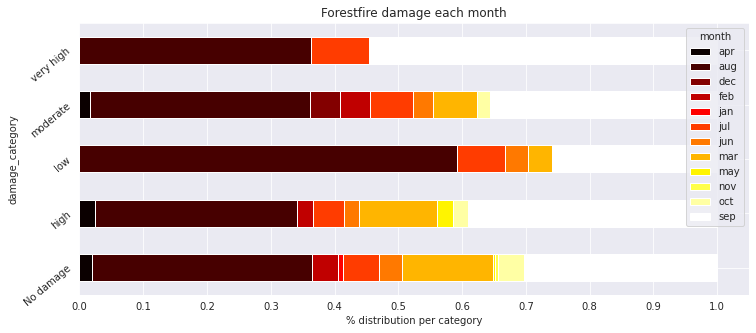

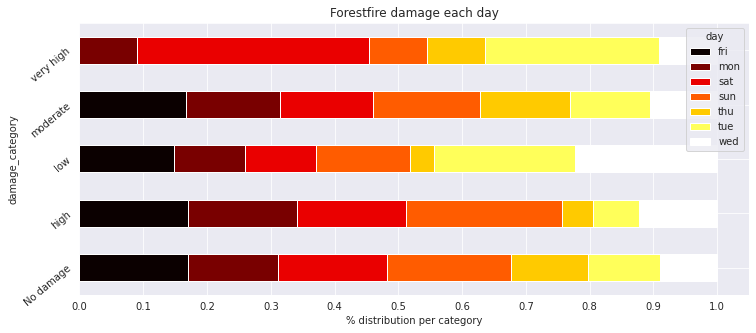

In [ ]:
for col in categorical_features:
    if col!="size_category":
        cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
        cross.plot.barh(stacked=True,rot=40,cmap='hot',figsize=(12, 5))
        plt.xlabel('% distribution per category')
        plt.xticks(np.arange(0,1.1,0.1))
        plt.title("Forestfire damage each {}".format(col))
        
plt.show()

[Text(0, 0.5, 'Temperature'),
 Text(0.5, 0, 'Months'),
 Text(0.5, 1.0, 'Month Vs Temp Barplot')]

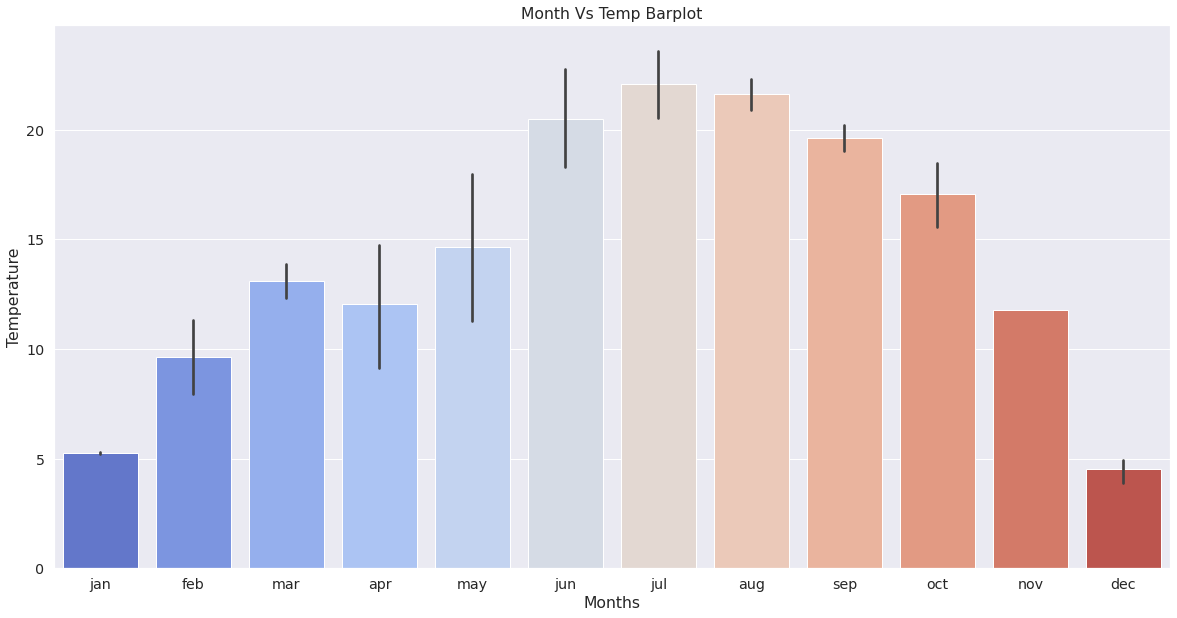

In [ ]:
# setting parameters
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style = "darkgrid", font_scale = 1.3)
month_temp = sns.barplot(x = 'month', y = 'temp', data = raw_data,
                         order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], palette = 'coolwarm');
month_temp.set(title = "Month Vs Temp Barplot", xlabel = "Months", ylabel = "Temperature")

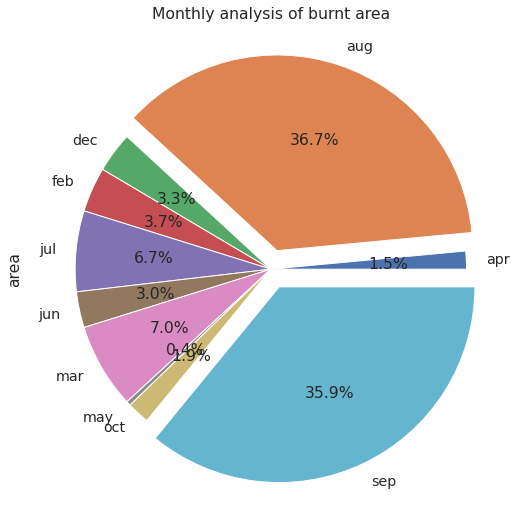

In [ ]:
# monthly analysis of burnt area, where the condition is: area>0
areaburnt=raw_data[raw_data['area']>0]
areaburnt.groupby('month')['area'].agg('count').plot(kind='pie',title='Monthly analysis of burnt area',figsize=(9,9),explode=[0,0.1,0,0,0,0,0,0,0,0.1],autopct='%0.1f%%')
plt.show()

Visualize the Large Forest Fire Size rate by month

In [ ]:
df1=raw_data.copy()
order={'month':{'jan':'January','feb':'February','mar':'March','apr':'April','may':'May','jun':'June','jul':'July','aug':'August','sep':'September','oct':'October','nov':'November','dec':'December'}}
df1=df1.replace(order)

count_month_response_pct = pd.crosstab(df1['size_category'],df1['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df1['month'].value_counts())
month['% Small Forest Fire'] = count_month_response_pct['small']
month['% Large Forest Fire'] = count_month_response_pct['large']
month.drop('month',axis = 1,inplace = True)
month['index'] = [8,9,3,7,2,6,10,4,12,1,5,11]
month = month.sort_values('index',ascending = True)
month.drop('index', axis=1,inplace=True)
month

,% Small Forest Fire,% Large Forest Fire
January,100.000000,0.000000
February,70.000000,30.000000
March,77.777778,22.222222
April,77.777778,22.222222
May,50.000000,50.000000
June,82.352941,17.647059
July,71.875000,28.125000
August,76.630435,23.369565
September,70.348837,29.651163
October,73.333333,26.666667


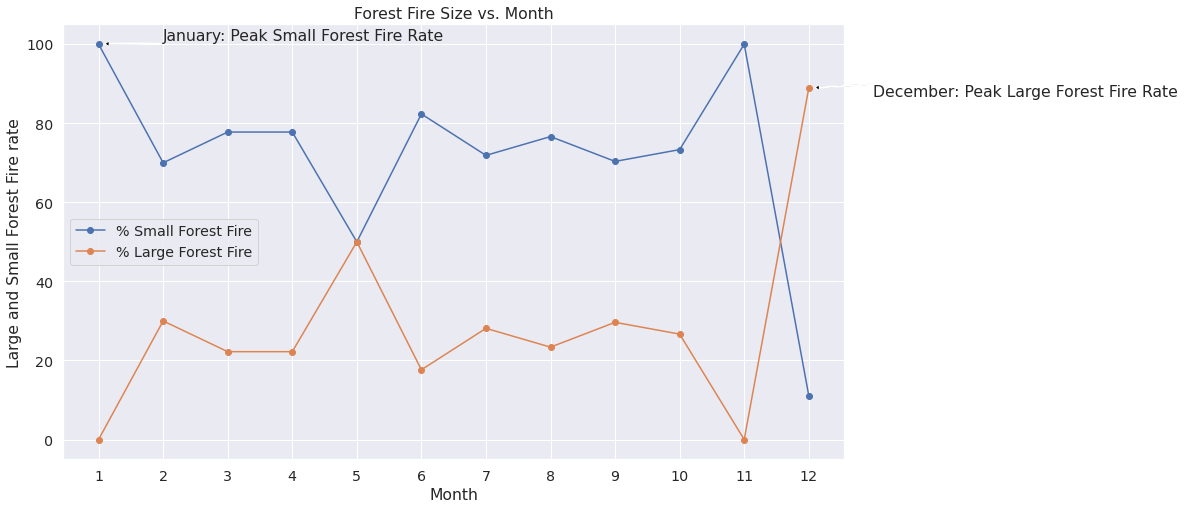

In [ ]:
#Change 'month' from words to numbers for easier analysis
df1=raw_data.copy()
order={'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
df1=df1.replace(order)

count_month_response_pct = pd.crosstab(df1['size_category'],df1['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df1['month'].value_counts())
month['% Small Forest Fire'] = count_month_response_pct['small']
month['% Large Forest Fire'] = count_month_response_pct['large']
month.drop('month',axis = 1,inplace = True)
month['Month'] = ['August','September','March','July','February','June','October','April','December','January','May','November']
month['index'] = [8,9,3,7,2,6,10,4,12,1,5,11]
month = month.sort_values('index',ascending = True)
month.drop('index', axis=1,inplace=True)
plot_month = month[['% Small Forest Fire','% Large Forest Fire']].plot(kind ='line',
                                                          figsize = (14,8),
                                                          marker = 'o')

plt.title('Forest Fire Size vs. Month')
plt.ylabel('Large and Small Forest Fire rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of Small fire rate
y = month['% Small Forest Fire'].max()
x = month['% Small Forest Fire'].idxmax()
plt.annotate('January: Peak Small Forest Fire Rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of large fire rate
y = month['% Large Forest Fire'].max()
x = month['% Large Forest Fire'].idxmax()
plt.annotate('December: Peak Large Forest Fire Rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()


In [ ]:
data_ = raw_data.copy()
data_.drop('size_category',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


Text(0.5, 1.0, 'Correlation with Forest Fire Size Category \n')

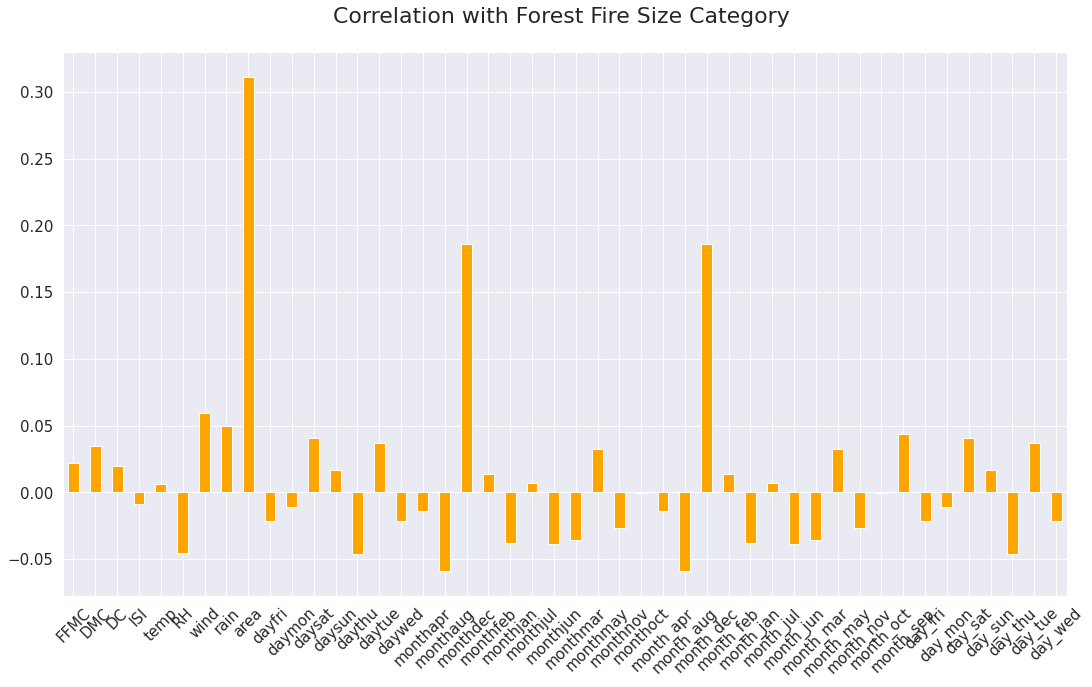

In [ ]:
df=raw_data.copy()
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)

correlations = data_.corrwith(df.size_category)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Forest Fire Size Category \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

In [ ]:
raw_data.size_category.unique()

array(['small', 'large'], dtype=object)

Checking for Imbalanced or balanced dataset with regards to the Target

In [ ]:
countsizesmall = len(raw_data[raw_data.size_category == 'small'])
countsizelarge = len(raw_data[raw_data.size_category == 'large'])
print("Percentage of Small Forest Fire Size: {:.2f}%".format((countsizesmall / (len(raw_data.size_category))*100)))
print("Percentage of Large Foreset Fire Size: {:.2f}%".format((countsizelarge / (len(raw_data.size_category))*100)))

Percentage of Small Forest Fire Size: 73.11%
Percentage of Large Foreset Fire Size: 26.89%


In [ ]:
raw_data.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

Text(0.5, 1.0, 'Forest Fire Size Category')

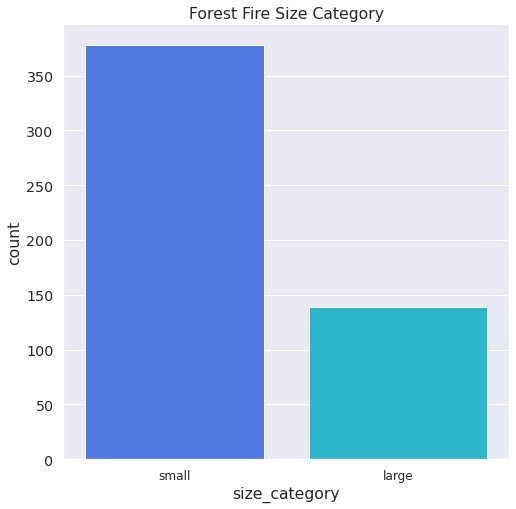

In [ ]:
plt.figure(figsize=(8,8))
pal = sns.color_palette('rainbow')
sns.countplot(x='size_category', data=raw_data, palette = pal, 
              order=raw_data['size_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Forest Fire Size Category')

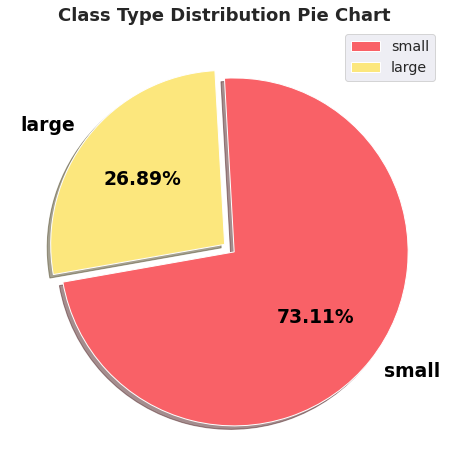

In [ ]:
plt.figure(figsize = (10,8))
plt.pie(raw_data['size_category'].value_counts(),
       labels=raw_data.size_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
        colors = ["#F96167", "#FCE77D"],
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()


**Data Pre-Processing**

Feature Engineering

In [ ]:
continuous_feature=[feature for feature in raw_data.columns if raw_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 28


In [ ]:
raw_data[continuous_feature]

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_standard_scaled = raw_data.copy()
features = df_standard_scaled[continuous_feature]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,2.254407,-0.408709,-0.440449,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,small
1,oct,tue,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,-0.443576,-0.408709,-0.440449,-0.474467,-0.365748,2.660475,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,-0.341512,-0.062318,-0.044023,5.785038,-0.706081,small
2,oct,sat,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,-0.443576,-0.408709,2.270410,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,-0.341512,-0.062318,-0.044023,5.785038,-0.706081,small
3,mar,fri,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,2.254407,-0.408709,-0.440449,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,small
4,mar,sun,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,-0.443576,-0.408709,-0.440449,2.107630,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,small


Now if we check the mean and standard deviation of our scaled data it should have a Mean '0' and Standard deviation '1'

In [ ]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1),'\n' 'Standard Devaition','\n',np.round(df_standard_scaled.std()),1)

Mean
 FFMC       -0.0
DMC        -0.0
DC          0.0
ISI         0.0
temp        0.0
RH          0.0
wind       -0.0
rain       -0.0
area        0.0
dayfri      0.0
daymon     -0.0
daysat     -0.0
daysun     -0.0
daythu     -0.0
daytue      0.0
daywed      0.0
monthapr    0.0
monthaug    0.0
monthdec   -0.0
monthfeb    0.0
monthjan    0.0
monthjul   -0.0
monthjun   -0.0
monthmar   -0.0
monthmay   -0.0
monthnov   -0.0
monthoct    0.0
monthsep    0.0
dtype: float64 
Standard Devaition 
 FFMC        1.0
DMC         1.0
DC          1.0
ISI         1.0
temp        1.0
RH          1.0
wind        1.0
rain        1.0
area        1.0
dayfri      1.0
daymon      1.0
daysat      1.0
daysun      1.0
daythu      1.0
daytue      1.0
daywed      1.0
monthapr    1.0
monthaug    1.0
monthdec    1.0
monthfeb    1.0
monthjan    1.0
monthjul    1.0
monthjun    1.0
monthmar    1.0
monthmay    1.0
monthnov    1.0
monthoct    1.0
monthsep    1.0
dtype: float64 1


In [ ]:
df = df_standard_scaled.copy()
df.drop('size_category',axis=1, inplace =True)
df = pd.get_dummies(df.iloc[:,:])
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,2.254407,-0.408709,-0.440449,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,-0.443576,-0.408709,-0.440449,-0.474467,-0.365748,2.660475,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,-0.341512,-0.062318,-0.044023,5.785038,-0.706081,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,-0.443576,-0.408709,2.270410,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,-0.341512,-0.062318,-0.044023,5.785038,-0.706081,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,2.254407,-0.408709,-0.440449,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,-0.443576,-0.408709,-0.440449,2.107630,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


Converting Categorical Variable into Label by using Get Dummies FeatureData Pre-Processing

In [ ]:
# Converting string value into binary classes such as if "large" than classify it as '1' else 'O'
df['size_category'] = raw_data.size_category
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,size_category
0,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,2.254407,-0.408709,-0.440449,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,-0.443576,-0.408709,-0.440449,-0.474467,-0.365748,2.660475,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,-0.341512,-0.062318,-0.044023,5.785038,-0.706081,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,-0.443576,-0.408709,2.270410,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,-0.341512,-0.062318,-0.044023,5.785038,-0.706081,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,2.254407,-0.408709,-0.440449,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,-0.443576,-0.408709,-0.440449,2.107630,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
raw_data.drop(['month','day','area'] ,axis=1, inplace= True)

In [ ]:
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,size_category
0,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,2.254407,-0.408709,-0.440449,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,-0.443576,-0.408709,-0.440449,-0.474467,-0.365748,2.660475,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,-0.341512,-0.062318,-0.044023,5.785038,-0.706081,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,-0.443576,-0.408709,2.270410,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,-0.341512,-0.062318,-0.044023,5.785038,-0.706081,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,2.254407,-0.408709,-0.440449,-0.474467,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,-0.443576,-0.408709,-0.440449,2.107630,-0.365748,-0.375873,-0.341512,-0.133103,-0.743339,-0.133103,-0.200603,-0.062318,-0.256865,-0.184391,2.928152,-0.062318,-0.044023,-0.172860,-0.706081,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
data_ = raw_data.copy()
data_.drop('size_category',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
data_['size_category'] = df1.size_category
data_.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,small
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,small
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small


In [ ]:
le = LabelEncoder()
le.fit(data_["size_category"])
data_["size_category"]=le.transform(data_["size_category"])
data_.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
# split into input (X) and output (y) variables
X = data_.drop('size_category', axis = 1)
y=  data_.size_category

In [ ]:
#Feature importance
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2

In [ ]:
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

In [ ]:
# summarize scores
scores = fit.scores_
features = fit.transform(X)

In [ ]:
score_df = pd.DataFrame(list(zip(scores, X.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
1,23.006108,DMC
2,21.872657,DC
17,17.601210,monthdec
5,6.350054,RH
7,5.216072,rain
6,1.440661,wind
16,1.157358,monthaug
12,0.964276,daythu
21,0.738170,monthjun
19,0.735450,monthjan


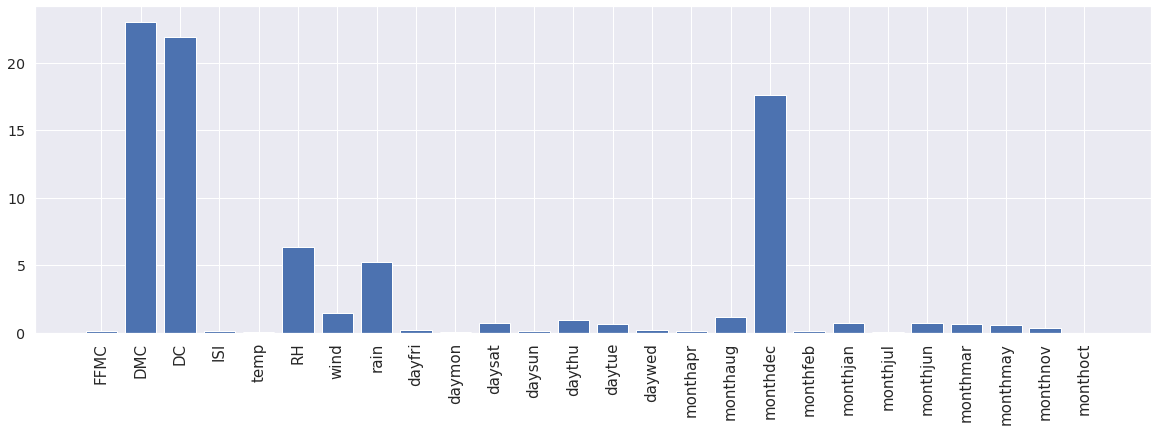

In [ ]:
# [0,1,2,3,4,5,6,7,8]
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks(range(len(scores)))
axes.set_xticklabels(X.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

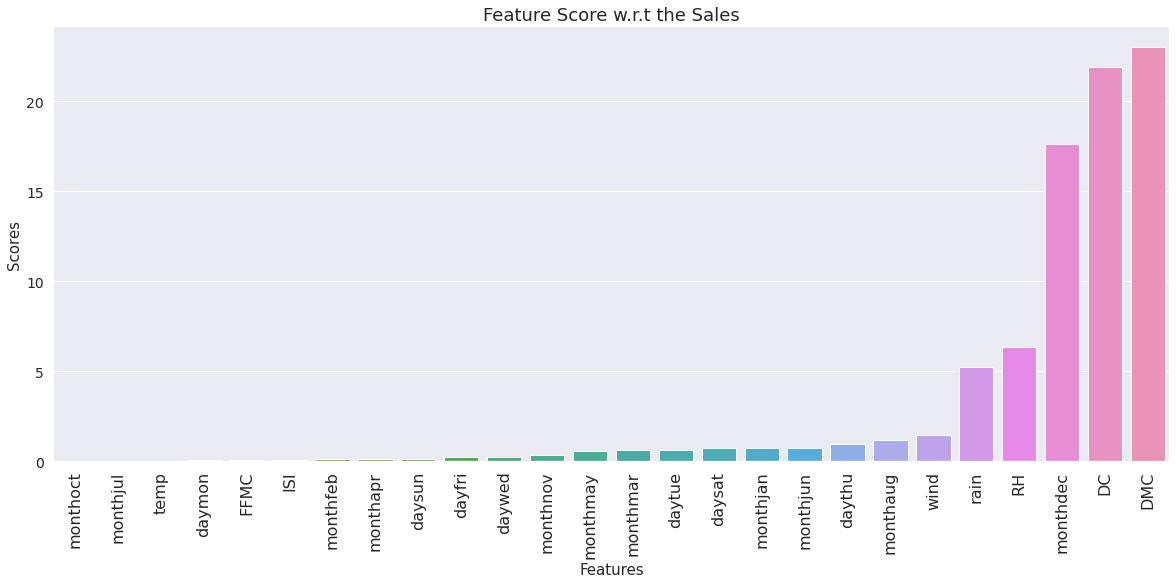

In [ ]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [ ]:
model_data=df[['DMC','DC','RH','rain','wind','area','month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep','size_category']]
model_data

,DMC,DC,RH,rain,wind,area,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,size_category
0,-1.323326,-1.830477,0.411724,-0.073268,1.498614,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-1.179541,0.488891,-0.692456,-0.073268,-1.741756,-0.202020,0,0,0,0,0,0,0,0,0,0,1,0,0
2,-1.049822,0.560715,-0.692456,-0.073268,-1.518282,-0.202020,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-1.212361,-1.898266,3.233519,0.603155,-0.009834,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.931043,-1.798600,3.356206,-0.073268,-1.238940,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,-0.846648,0.474768,-0.753800,-0.073268,-0.736124,-0.100753,0,1,0,0,0,0,0,0,0,0,0,0,1
513,-0.846648,0.474768,1.638592,-0.073268,0.995798,0.651674,0,1,0,0,0,0,0,0,0,0,0,0,1
514,-0.846648,0.474768,1.577248,-0.073268,1.498614,-0.026532,0,1,0,0,0,0,0,0,0,0,0,0,1
515,0.549003,0.269382,-0.140366,-0.073268,-0.009834,-0.202020,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
x = model_data.drop('size_category',axis=1)
y = model_data[['size_category']]

In [ ]:
# Splitting data into test data and train data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3, stratify=y)

**Hyperparameter Tuning**

 Optimal Learning rate ,Number of Layers and Neurons

In [ ]:
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=100,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(build_model,objective='val_accuracy',max_trials=5,  executions_per_trial=3,directory='project',project_name='Forest Fire')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(x_train, y_train,epochs=100,validation_data=(x_test, y_test))

Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.9807692170143127

Best val_accuracy So Far: 0.9807692170143127
Total elapsed time: 00h 04m 03s


In [ ]:
tuner.results_summary()

Results summary
Results in project/Forest Fire
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 64
units_1: 32
learning_rate: 0.01
units_2: 32
units_3: 64
units_4: 64
units_5: 64
units_6: 64
units_7: 96
units_8: 32
units_9: 64
units_10: 32
units_11: 64
units_12: 96
units_13: 96
units_14: 64
units_15: 64
units_16: 32
units_17: 96
units_18: 64
Score: 0.9807692170143127
Trial summary
Hyperparameters:
num_layers: 12
units_0: 64
units_1: 32
learning_rate: 0.01
units_2: 32
units_3: 96
units_4: 32
units_5: 64
units_6: 64
units_7: 96
units_8: 64
units_9: 64
units_10: 32
units_11: 32
units_12: 96
units_13: 96
units_14: 32
units_15: 64
units_16: 32
units_17: 64
units_18: 64
Score: 0.9786324699719747
Trial summary
Hyperparameters:
num_layers: 19
units_0: 96
units_1: 96
learning_rate: 0.001
units_2: 96
units_3: 64
units_4: 96
units_5: 32
units_6: 64
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
units_16

**Hyperparameter Tuning: Optimal Batch_size, Number of Epochs**

In [ ]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(64,input_dim=18,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(units=1,activation="sigmoid"))
    
    adam=Adam(learning_rate=0.01)
    model1.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
    return model1

In [ ]:
model1 =KerasClassifier(build_fn=create_model,verbose=0)
batch_size=[10,20,40,50]
epochs=[10,50,100,200]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=KFold(),verbose=10)

In [ ]:
grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ....batch_size=10, epochs=10;, score=0.875 total time=   3.3s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ....batch_size=10, epochs=10;, score=0.968 total time=   1.4s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ....batch_size=10, epochs=10;, score=0.871 total time=   1.3s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ....batch_size=10, epochs=10;, score=0.839 total time=   1.4s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ....batch_size=10, epochs=10;, score=0.903 total time=   1.3s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ....batch_size=10, epochs=50;

[CV 3/5; 5/16] END ....batch_size=20, epochs=10;, score=0.903 total time=   1.2s
[CV 4/5; 5/16] START batch_size=20, epochs=10...................................


[CV 4/5; 5/16] END ....batch_size=20, epochs=10;, score=0.903 total time=   1.3s
[CV 5/5; 5/16] START batch_size=20, epochs=10...................................
[CV 5/5; 5/16] END ....batch_size=20, epochs=10;, score=0.968 total time=   1.3s
[CV 1/5; 6/16] START batch_size=20, epochs=50...................................
[CV 1/5; 6/16] END ....batch_size=20, epochs=50;, score=0.844 total time=   1.8s
[CV 2/5; 6/16] START batch_size=20, epochs=50...................................
[CV 2/5; 6/16] END ....batch_size=20, epochs=50;, score=0.968 total time=   2.3s
[CV 3/5; 6/16] START batch_size=20, epochs=50...................................
[CV 3/5; 6/16] END ....batch_size=20, epochs=50;, score=0.871 total time=   1.8s
[CV 4/5; 6/16] START batch_size=20, epochs=50...................................
[CV 4/5; 6/16] END ....batch_size=20, epochs=50;, score=0.968 total time=   2.3s
[CV 5/5; 6/16] START batch_size=20, epochs=50...................................
[CV 5/5; 6/16] END ....batch

In [ ]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best 0.9620967626571655, using {'batch_size': 10, 'epochs': 50}
0.8911290168762207,0.04342874244632797 with {'batch_size': 10, 'epochs': 10}
0.9620967626571655,0.04587568455888755 with {'batch_size': 10, 'epochs': 50}
0.9556451559066772,0.04688529464881791 with {'batch_size': 10, 'epochs': 100}
0.9618951559066773,0.03669354719120254 with {'batch_size': 10, 'epochs': 200}
0.9360886931419372,0.04034072597103015 with {'batch_size': 20, 'epochs': 10}
0.9235886931419373,0.054757099651404496 with {'batch_size': 20, 'epochs': 50}
0.9431451439857483,0.0665065868904682 with {'batch_size': 20, 'epochs': 100}
0.9300403118133544,0.0454930832822553 with {'batch_size': 20, 'epochs': 200}
0.8784274101257324,0.07959907077941365 with {'batch_size': 40, 'epochs': 10}
0.9620967626571655,0.04587568455888755 with {'batch_size': 40, 'epochs': 50}
0.9427419185638428,0.03610164807752721 with {'batch_size': 40, 'epochs': 100}
0.9556451559066772,0.04688529464881791 with {'batch_size': 40, 'epochs': 200}
0.89798

**Hyperparameter Tuning: Optimal Droupout rate**

In [ ]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(64,input_dim=18,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(units=1,activation="sigmoid"))
    
    adam=Adam(lr=0.01)
    model2.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
    return model2

In [ ]:
model2=KerasClassifier(build_fn=create_model,batch_size=10,epochs=100,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)

In [ ]:
grid_result2 = grid2.fit(x_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END .............dropout_rate=0.0;, score=0.844 total time=  12.9s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END .............dropout_rate=0.0;, score=1.000 total time=   6.4s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END .............dropout_rate=0.0;, score=0.968 total time=   4.0s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END .............dropout_rate=0.0;, score=1.000 total time=   4.4s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END .............dropout_rate=0.0;, score=0.968 total time=   6.1s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END .............dropout_rate=0.1;,

In [ ]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best 0.9620967626571655, using {'dropout_rate': 0.5}
0.9558467626571655,0.0578751930187807 with {'dropout_rate': 0.0}
0.9425402998924255,0.03088035079386977 with {'dropout_rate': 0.1}
0.9493951559066772,0.05798745815381063 with {'dropout_rate': 0.2}
0.9556451439857483,0.04221371222927085 with {'dropout_rate': 0.3}
0.94919353723526,0.04233678433220251 with {'dropout_rate': 0.4}
0.9620967626571655,0.04587568455888755 with {'dropout_rate': 0.5}


**Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer**

In [ ]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(64,input_dim=18,activation='relu'))
    model3.add(Dropout(0.0))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.0))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.0))
    model3.add(Dense(units=1,activation="sigmoid"))
    
    adam=Adam(lr=0.01)
    model3.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
    return model3

In [ ]:
model3=KerasClassifier(build_fn=create_model,batch_size=10,epochs=100,verbose=0)
activation_function=['softmax','tanh','relu']
init=['normal','uniform','zero']
param_grid=dict(activation_function=activation_function,init=init)
grid3 = GridSearchCV(estimator=model3,param_grid=param_grid,cv=KFold(),verbose=10)

In [ ]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=0.812 total time=   6.2s
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=1.000 total time=   4.0s
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=0.935 total time=   6.1s
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=1.000 total time=   6.1s
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=0.968 total time=   6.1s
[CV 1/5; 2/9] START activation_function=softmax, init=uniform..............

In [ ]:
print('Best {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best 0.9620967626571655, using {'activation_function': 'tanh', 'init': 'normal'}
0.9431451559066772,0.06956550691235855 with {'activation_function': 'softmax', 'init': 'normal'}
0.9362903118133545,0.03387095701126977 with {'activation_function': 'softmax', 'init': 'uniform'}
0.9493951439857483,0.05427993920407009 with {'activation_function': 'softmax', 'init': 'zero'}
0.9620967626571655,0.04587568455888755 with {'activation_function': 'tanh', 'init': 'normal'}
0.9620967626571655,0.04587568455888755 with {'activation_function': 'tanh', 'init': 'uniform'}
0.9620967626571655,0.04587568455888755 with {'activation_function': 'tanh', 'init': 'zero'}
0.9298386931419372,0.03638874737620478 with {'activation_function': 'relu', 'init': 'normal'}
0.9427419185638428,0.03610164807752721 with {'activation_function': 'relu', 'init': 'uniform'}
0.94919353723526,0.04233678433220251 with {'activation_function': 'relu', 'init': 'zero'}


**Building Neural Networks Model using Optimal Values**

Initialising the ANN

In [ ]:
def toFindBestParams(x_train, y_train, x_test, y_test):
    #print(y_test.shape)
    #sys.exit()
    
    #defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20]
    epoch_list      = [5 , 10 , 50 , 100]
           
    # initializing the trials
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train.shape[1], kernel_initializer='normal', activation='tanh'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=6, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
 
            # Compiling the model
            model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])
 
            # Fitting the ANN to the Training set
            model_trained = model.fit(x_train, y_train ,batch_size = batch_trial, epochs = epochs_trial, verbose=0)
               
             # Fetching the accuracy of the training
            Accuracy_train = model_trained.history['accuracy'][-1]   
            
            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',Accuracy_train)

# Calling the function
toFindBestParams(x_train, y_train, x_test, y_test)


batch_size: 5 - epochs: 5 Accuracy: 0.8476454019546509
batch_size: 5 - epochs: 10 Accuracy: 0.9473684430122375
batch_size: 5 - epochs: 50 Accuracy: 0.9944598078727722
batch_size: 5 - epochs: 100 Accuracy: 0.9972299337387085
batch_size: 10 - epochs: 5 Accuracy: 0.7756232619285583
batch_size: 10 - epochs: 10 Accuracy: 0.8698061108589172
batch_size: 10 - epochs: 50 Accuracy: 0.9916897416114807
batch_size: 10 - epochs: 100 Accuracy: 0.9944598078727722
batch_size: 15 - epochs: 5 Accuracy: 0.761772871017456
batch_size: 15 - epochs: 10 Accuracy: 0.8199446201324463
batch_size: 15 - epochs: 50 Accuracy: 0.9944598078727722
batch_size: 15 - epochs: 100 Accuracy: 1.0
batch_size: 20 - epochs: 5 Accuracy: 0.7534626126289368
batch_size: 20 - epochs: 10 Accuracy: 0.7922437787055969
batch_size: 20 - epochs: 50 Accuracy: 0.9778393507003784
batch_size: 20 - epochs: 100 Accuracy: 0.9861496090888977


**Training Model - using best params**

In [ ]:
# create ANN model
model = Sequential()
# Defining the first layer of the model
model.add(Dense(units=50, input_dim=x_train.shape[1], kernel_initializer='normal', activation='tanh'))
#model3.add(Dropout(0.1))        
# Defining the Second layer of the model
model.add(Dense(units=6, kernel_initializer='normal', activation='tanh'))
# model.add(Dropout(0.1))  
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with best parameters
history = model.fit(x_train, y_train, validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
25/25 [==============================] - 1s 12ms/step - loss: 0.6855 - accuracy: 0.7718 - val_loss: 0.6806 - val_accuracy: 0.7000
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6609 - accuracy: 0.7676 - val_loss: 0.6536 - val_accuracy: 0.7083
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.7718 - val_loss: 0.6114 - val_accuracy: 0.7167
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.5596 - accuracy: 0.7718 - val_loss: 0.5826 - val_accuracy: 0.7167
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5269 - accuracy: 0.7759 - val_loss: 0.5696 - val_accuracy: 0.7417
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5047 - accuracy: 0.7801 - val_loss: 0.5562 - val_accuracy: 0.7417
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4868 - accuracy: 0.7884 - val_loss: 0.5437 - val_accuracy: 0.7417
Epoch 8/100


**Model Evaluation Train and Test Error**

In [ ]:
# evaluate the model
scores = model.evaluate(x, y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

17/17 [==============================] - 0s 5ms/step - loss: 0.1021 - accuracy: 0.9768
accuracy: 97.68%


**Compare the train-set and test-set accuracy**

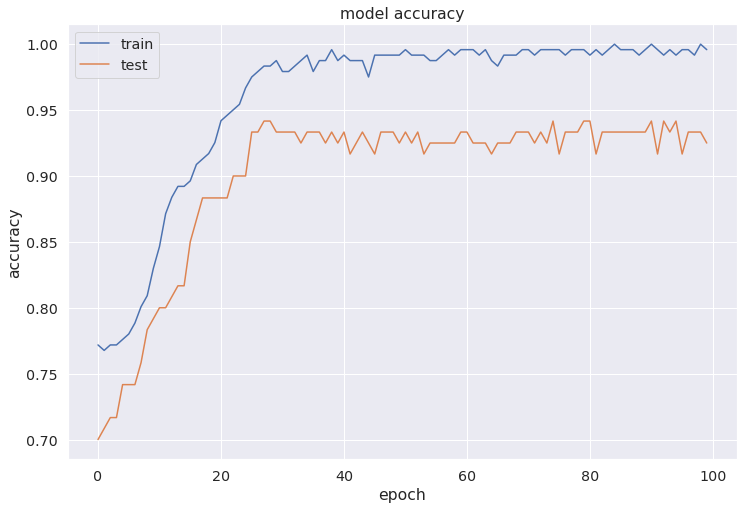

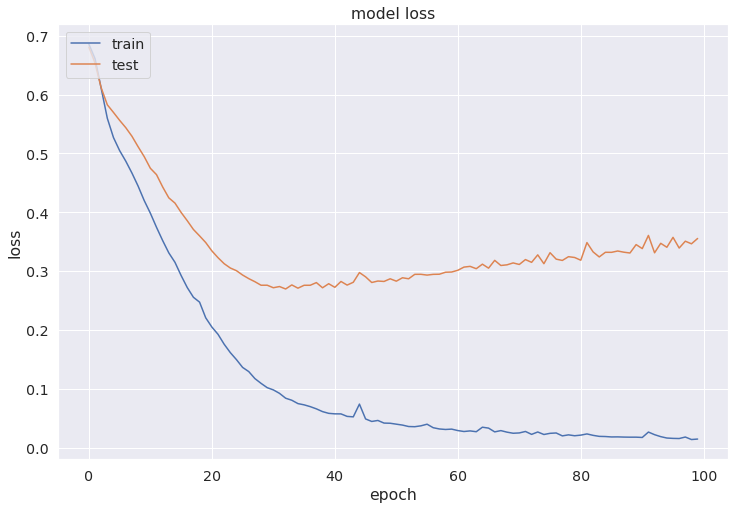

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Predicting values from Model using same dataset**

In [ ]:
# generating predictions for test data
y_predict_test = model.predict(x_test) 

# creating table with test price & predicted price for test
test_prediction = pd.DataFrame()
test_prediction['Test_Actual'] = y_test.size_category
test_prediction['Test_Probability'] = y_predict_test
def probToBinary(varProb):
    if varProb >= 0.5:
        return 1
    else:
        return 0

# converting the probability of target variable to binary class of test data
test_prediction['Test_Predicted'] = test_prediction['Test_Probability'].apply(probToBinary)
print(test_prediction.shape)
test_prediction.head(10)

5/5 [==============================] - 0s 5ms/step
(156, 3)


,Test_Actual,Test_Probability,Test_Predicted
493,1,0.997189,1
298,0,0.001713,0
93,0,0.002045,0
437,0,0.002505,0
340,0,0.018608,0
7,0,0.002051,0
172,0,0.006229,0
76,0,0.002330,0
148,0,0.002680,0
104,0,0.001749,0


In [ ]:
# generating predictions for train data
y_predict_train = model.predict(x_train)

# creating table with test price & predicted price for test
train_prediction = pd.DataFrame()
train_prediction['Train_Actual'] = y_train.size_category
train_prediction['Train_Probability'] = y_predict_train
train_prediction['Train_Predicted'] = train_prediction['Train_Probability'].apply(probToBinary)
print(train_prediction.shape)
train_prediction.head(10)

12/12 [==============================] - 0s 3ms/step
(361, 3)


,Train_Actual,Train_Probability,Train_Predicted
115,0,0.002798,0
130,0,0.002466,0
413,0,0.002338,0
350,0,0.012115,0
103,0,0.001921,0
511,0,0.002068,0
325,0,0.001981,0
473,1,0.997189,1
265,0,0.002215,0
226,1,0.997189,1


Text(0, 0.5, 'Frequency')

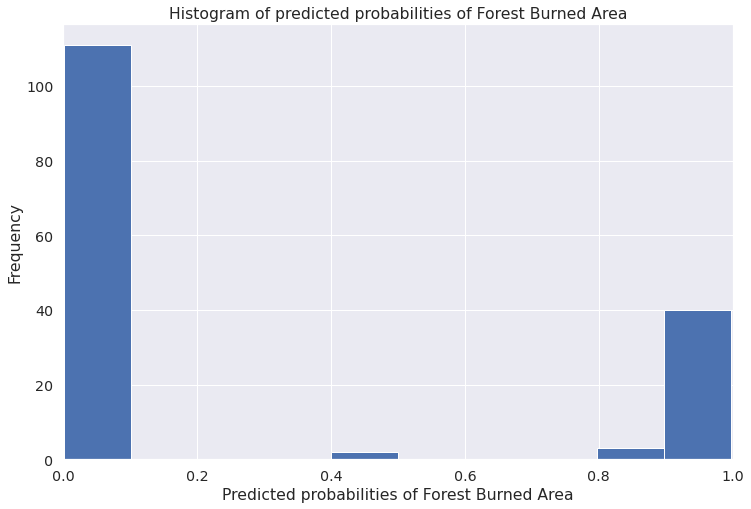

In [ ]:
# plot histogram of predicted probabilities

plt.figure(figsize=(12,8))
# adjust the font size 
plt.rcParams['font.size'] = 12


# plot histogram with 10 bins
plt.hist(test_prediction['Test_Probability'], bins = 10)


# set the title of predicted probabilities
plt.title('Histogram of predicted probabilities of Forest Burned Area')


# set the x-axis limit
plt.xlim(0,1)


# set the title
plt.xlabel('Predicted probabilities of Forest Burned Area')
plt.ylabel('Frequency')